# This file loads the intermediary dataset and creates the final dataset used in our analysis

### Necessary Imports and loading the datasets

In [1]:
import pandas as pd
import numpy as np
import pandas_datareader as pdr
import yfinance as yf
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import timedelta
import matplotlib.ticker as mtick
import matplotlib.dates as mpl_dates

import warnings
warnings.filterwarnings("ignore")

inter_df = pd.read_csv("OutputData/inter.csv")
inter_df["Date"] = pd.to_datetime(inter_df["Date"])
event_dates = pd.read_csv("InputData/MajorEvents.csv")
event_dates['Date'] = pd.to_datetime(event_dates['Date'])

### Calculating cumulative returns around event dates for every industry 

In [2]:
event_ret_df = pd.DataFrame()
industries = ['Food', 'Transport', 'Semiconductor', 'Energy', 'Metal']
for index, row in event_dates.iterrows():
    event = row['Event']
    date = row['Date']
    # Define the start and end dates for the subset
    start_date = pd.to_datetime(date) - pd.Timedelta(days=20)
    end_date = pd.to_datetime(date) + pd.Timedelta(days=20)

    for industry in industries:
        sub_df = inter_df.query("Date >= @start_date and Date <= @end_date and Industry == @industry")
        sub_df_cum = sub_df.assign(R=1+sub_df['Excess Returns']).assign(cumret=lambda x: x.groupby(['Firm'])['R'].cumprod()).groupby(['Date'])['cumret'].mean().reset_index(name='Cum_ret')
        sub_df_cum["Event"] = event
        sub_df_cum["EventDate"] = date
        sub_df_cum["Industry"] = industry
        event_ret_df = pd.concat([event_ret_df, sub_df_cum])

event_ret_df["Cum_ret"] = event_ret_df["Cum_ret"] - 1
event_ret_df["EventDate"] = pd.to_datetime(event_ret_df["EventDate"])
event_ret_df["Date"] = pd.to_datetime(event_ret_df["Date"])
event_ret_df.to_csv("OutputData/final.csv")
event_ret_df.head(10)

Date   Cum_ret                  Event  EventDate Industry
0 2022-02-04 -0.019062  Invasion Announcement 2022-02-24     Food
1 2022-02-07 -0.003971  Invasion Announcement 2022-02-24     Food
2 2022-02-08 -0.002236  Invasion Announcement 2022-02-24     Food
3 2022-02-09 -0.013325  Invasion Announcement 2022-02-24     Food
4 2022-02-10 -0.006935  Invasion Announcement 2022-02-24     Food
5 2022-02-11  0.019084  Invasion Announcement 2022-02-24     Food
6 2022-02-14  0.024064  Invasion Announcement 2022-02-24     Food
7 2022-02-15  0.013449  Invasion Announcement 2022-02-24     Food
8 2022-02-16  0.013016  Invasion Announcement 2022-02-24     Food
9 2022-02-17  0.036416  Invasion Announcement 2022-02-24     Food

## Calculating Return differences from event dates (t) to selected days after the event
### Getting Industry Returns at time t, t+3, t+10, and t+20

In [3]:
rets = []
industries = ['Food', 'Transport', 'Semiconductor', 'Energy', 'Metal']
for index, row in event_dates.iterrows():
    event = row['Event']
    date = row['Date']

    sub_df = event_ret_df.query("Event == @event")
    sub_df['Date'] = pd.to_datetime(sub_df['Date'])
    last_date = sub_df['Date'].max()
    date1 = date + pd.Timedelta(days=3)
    date2 = date + pd.Timedelta(days=10)
    date3 = min(date + pd.Timedelta(days=20), last_date)
    
    plt.figure(figsize=(8, 6))
    for industry in industries:
        industry_df = sub_df[sub_df['Industry'] == industry]
        sns.lineplot(x='Date', y='Cum_ret', data=industry_df, label=industry)
    
    plt.axvline(date, color='red', linestyle='--', label='Event Date')
    plt.axvline(date1, color='red', linestyle='--', label='Event Date + 3')
    plt.axvline(date2, color='red', linestyle='--', label='Event Date + 10')
    plt.axvline(date3, color='red', linestyle='--', label='Event Date + 20')
    plt.xlim(date - pd.Timedelta(days=20), date + pd.Timedelta(days=20))
    
    for line in plt.gca().lines:
        if line.get_label() in industries: 
            x = mpl_dates.date2num(date)
            x1 = mpl_dates.date2num(date1)
            x2 = mpl_dates.date2num(date2)
            x3 = mpl_dates.date2num(date3)
            y = np.interp(x, line.get_xdata().astype(np.float64), line.get_ydata().astype(np.float64))
            y1 = np.interp(x1, line.get_xdata().astype(np.float64), line.get_ydata().astype(np.float64))
            y2 = np.interp(x2, line.get_xdata().astype(np.float64), line.get_ydata().astype(np.float64))
            y3 = np.interp(x3, line.get_xdata().astype(np.float64), line.get_ydata().astype(np.float64))
            result = {"Date": date, "Industry": line.get_label(), 'ret0': y, "ret3": y1, "ret10": y2, "ret20": y3}
            rets.append(result)
    
    plt.close()

rets_df = pd.DataFrame(rets)

### Calculating return differences between t and t+3, t+10, and t+20

In [4]:
rets_df["retDiff3"] = rets_df["ret3"] - rets_df["ret0"]
rets_df["retDiff10"] = rets_df["ret10"] - rets_df["ret0"]
rets_df["retDiff20"] = rets_df["ret20"] - rets_df["ret0"]
rets_df = rets_df.drop(['ret3', 'ret10', 'ret20', 'ret0'], axis=1)
rets_df.rename(columns = {"retDiff3": "ret3", "retDiff10": "ret10", "retDiff20": "ret20"}, inplace = True)
rets_df.to_csv("OutputData/RetDiff.csv")
rets_df.head(10)

Date       Industry      ret3     ret10     ret20
0 2022-02-24           Food  0.010206  0.021588 -0.035195
1 2022-02-24      Transport  0.005687 -0.035341  0.029181
2 2022-02-24  Semiconductor -0.008892 -0.077437 -0.037119
3 2022-02-24         Energy  0.026801  0.178254  0.076110
4 2022-02-24          Metal  0.046522  0.127898  0.123322
5 2022-02-25           Food -0.005246  0.012370 -0.056857
6 2022-02-25      Transport  0.004957 -0.047044  0.022394
7 2022-02-25  Semiconductor  0.003818 -0.069432 -0.023556
8 2022-02-25         Energy  0.047286  0.200603  0.123199
9 2022-02-25          Metal -0.001552  0.079535  0.085840

### Plotting industry cumulative returns for all events (all industries)

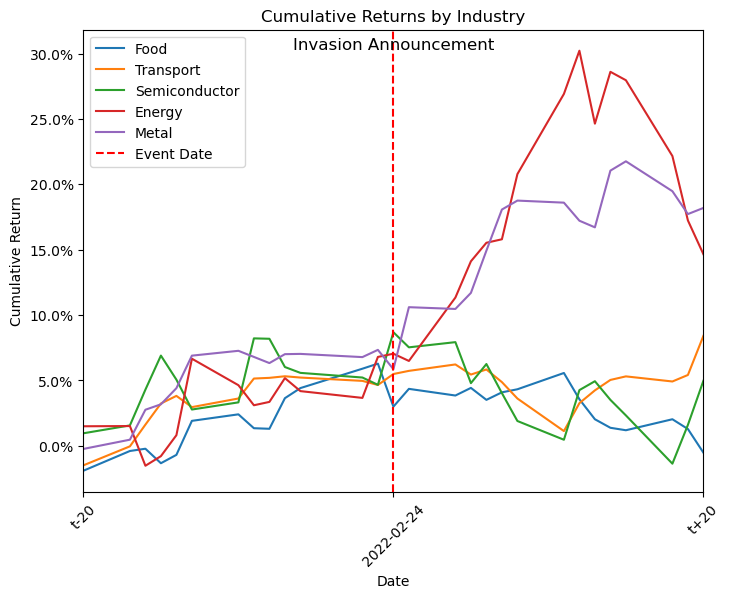

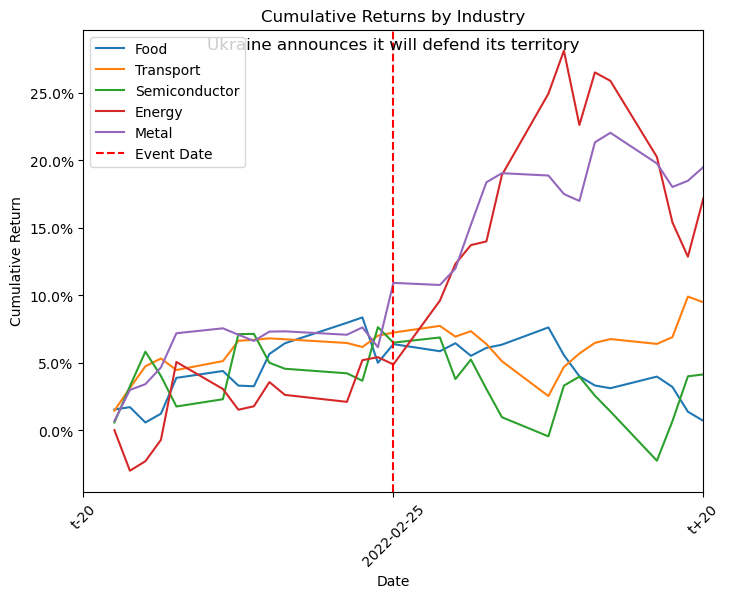

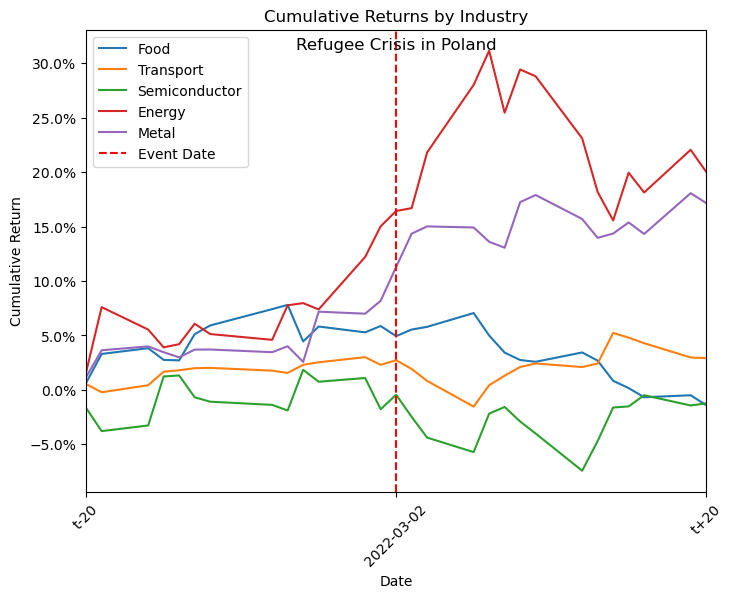

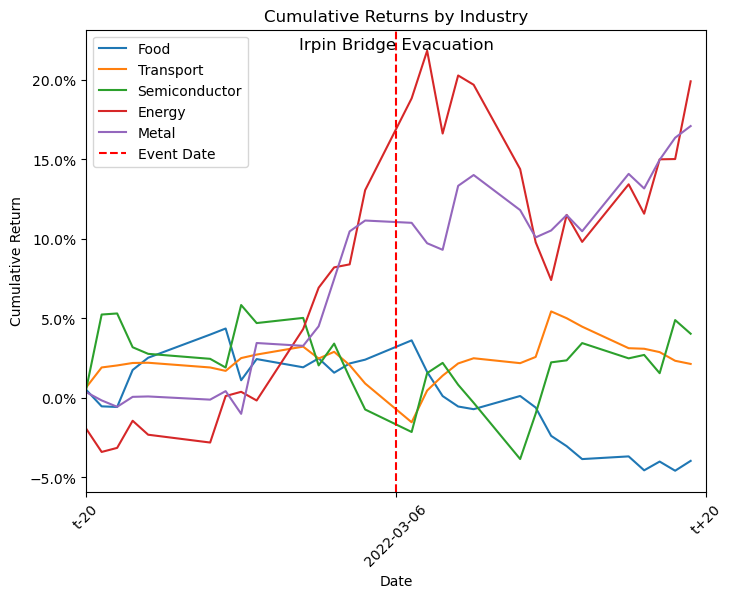

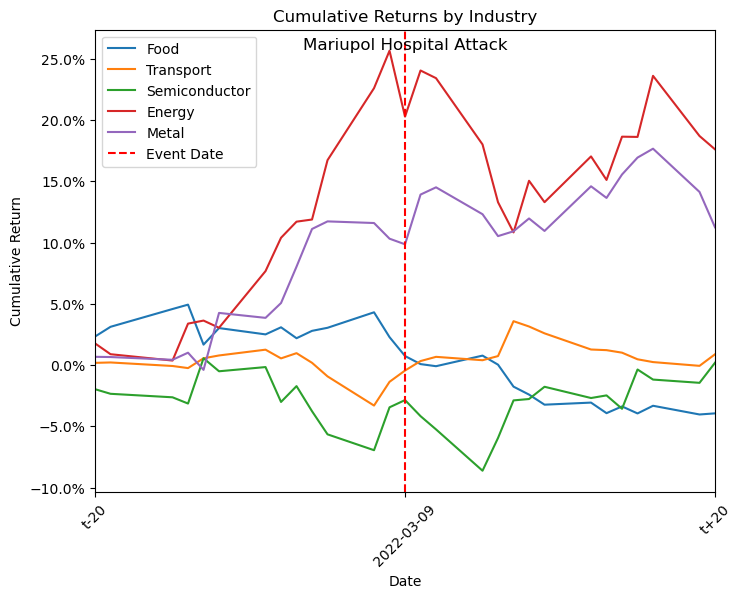

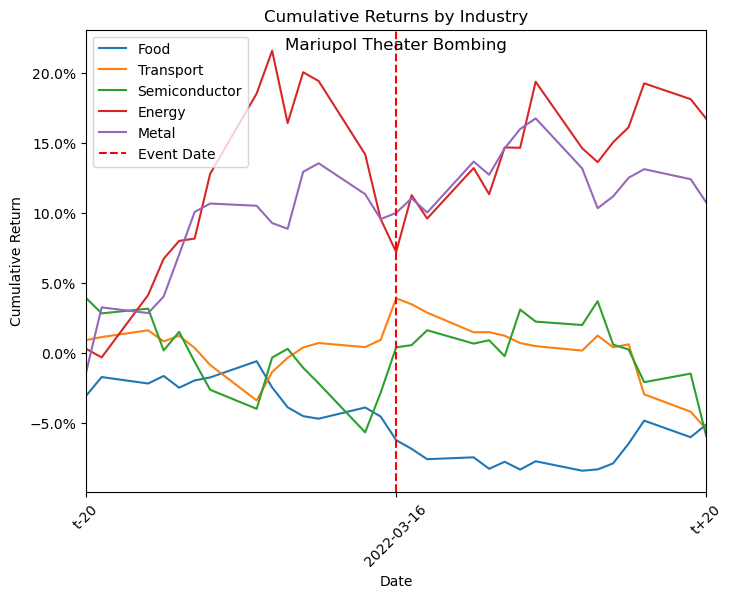

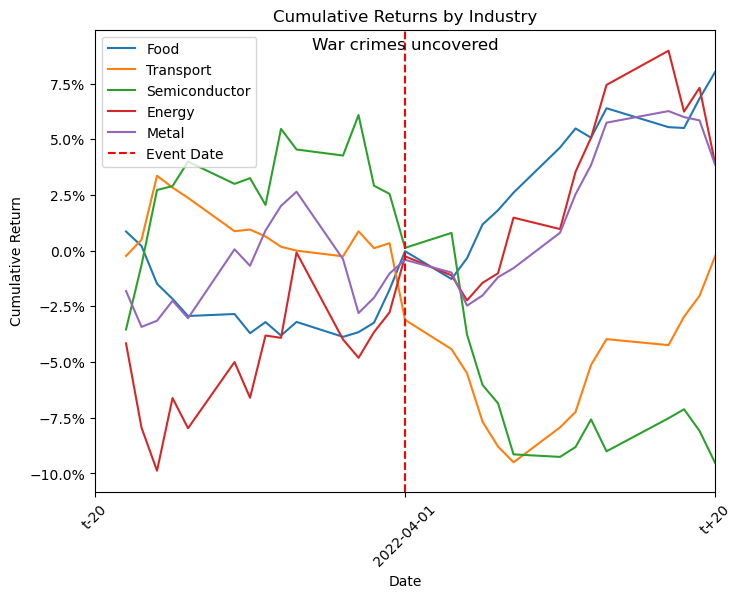

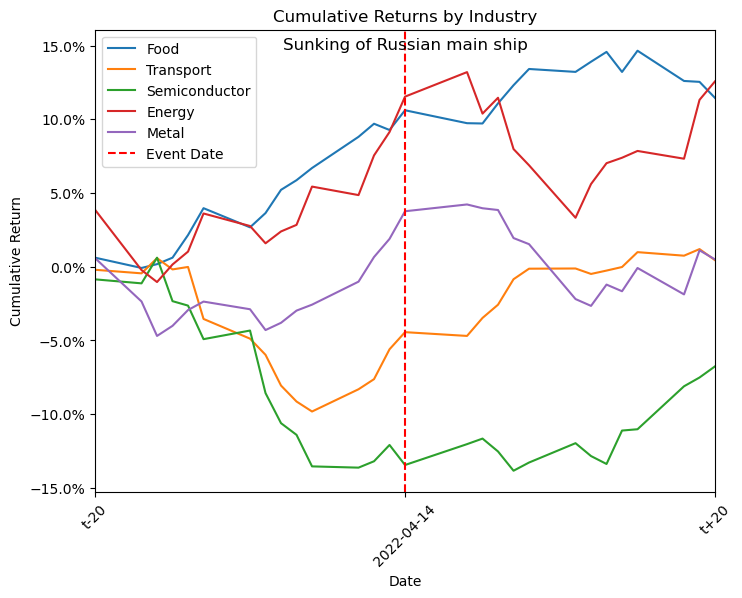

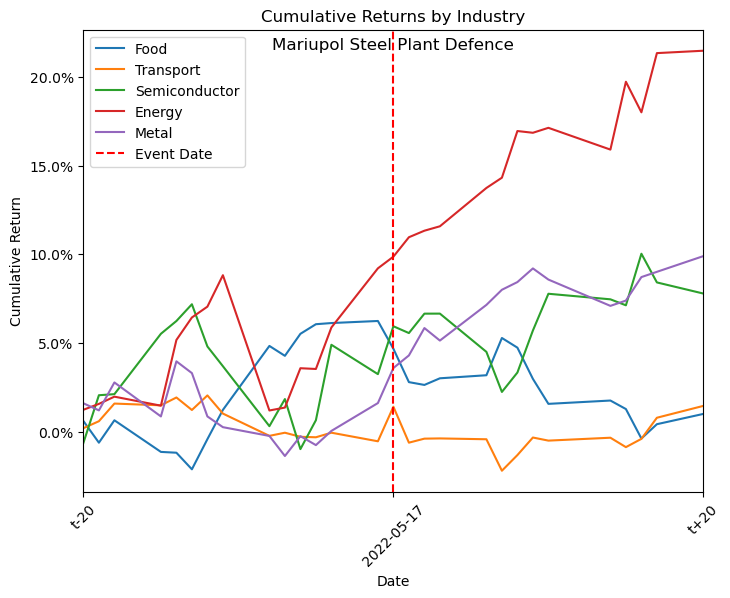

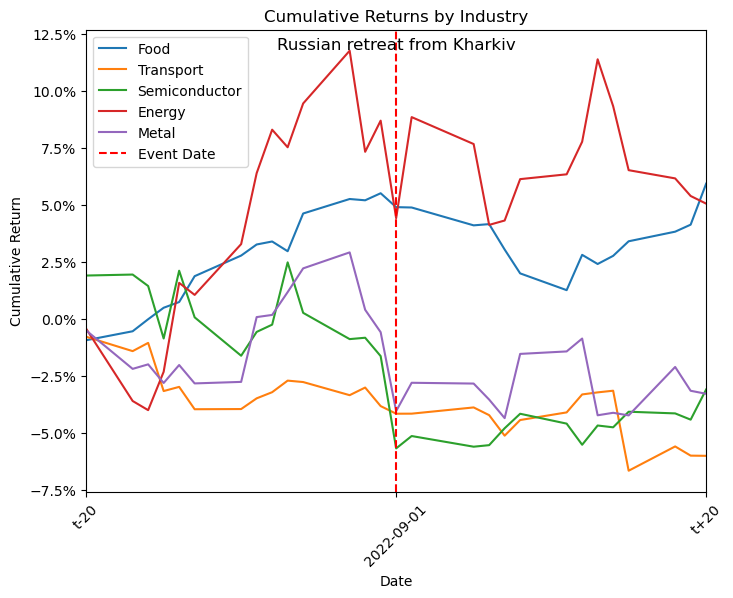

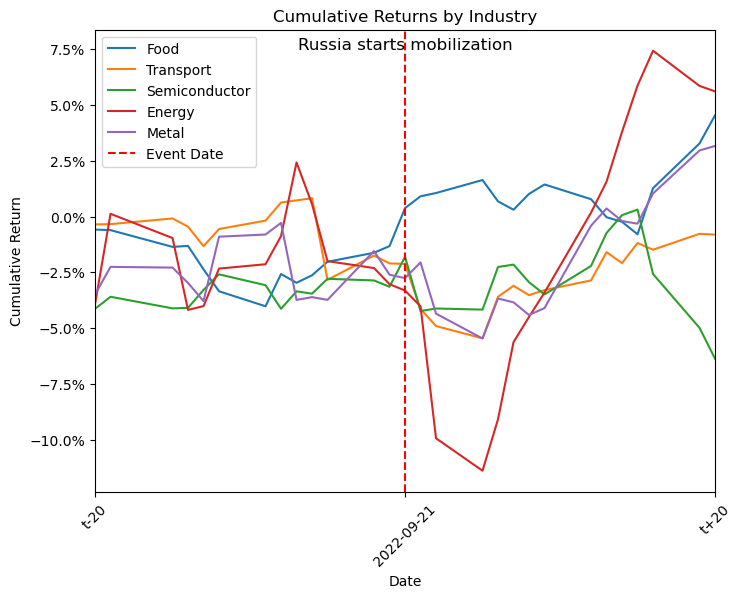

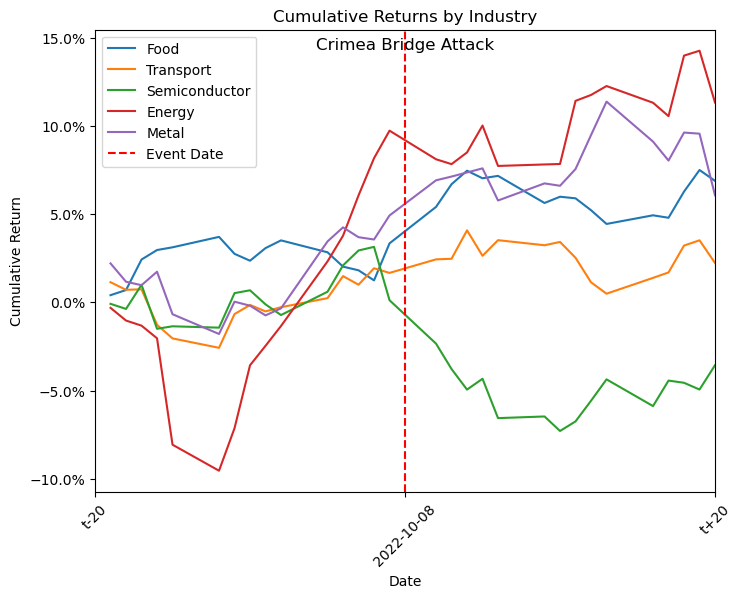

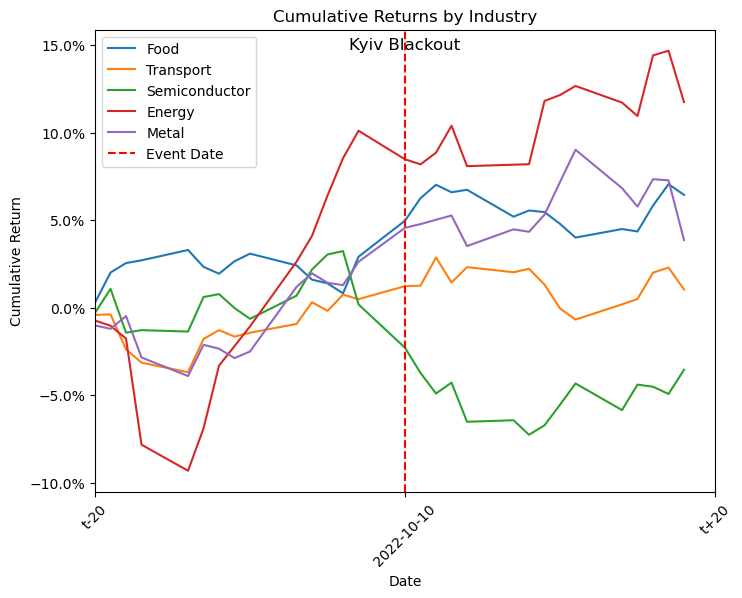

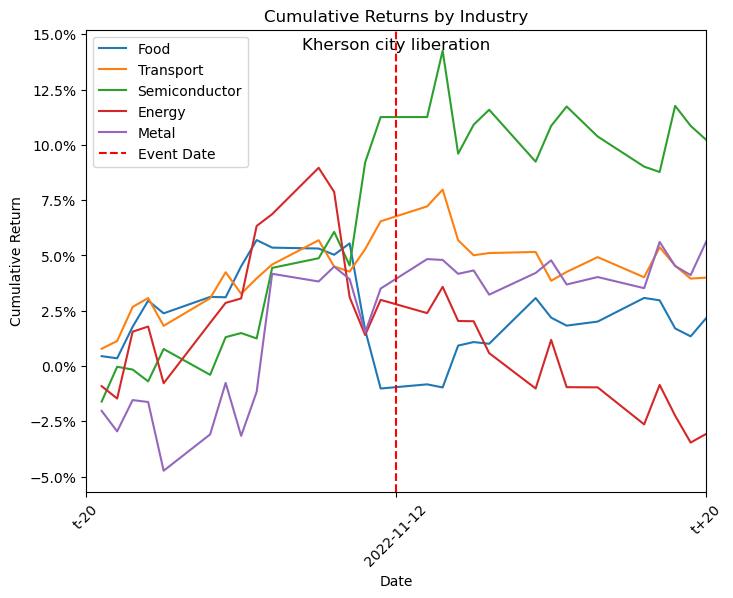

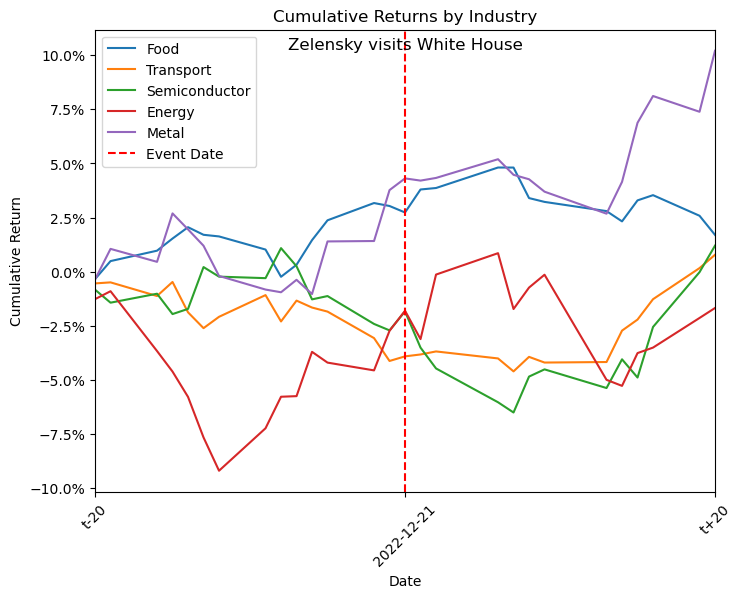

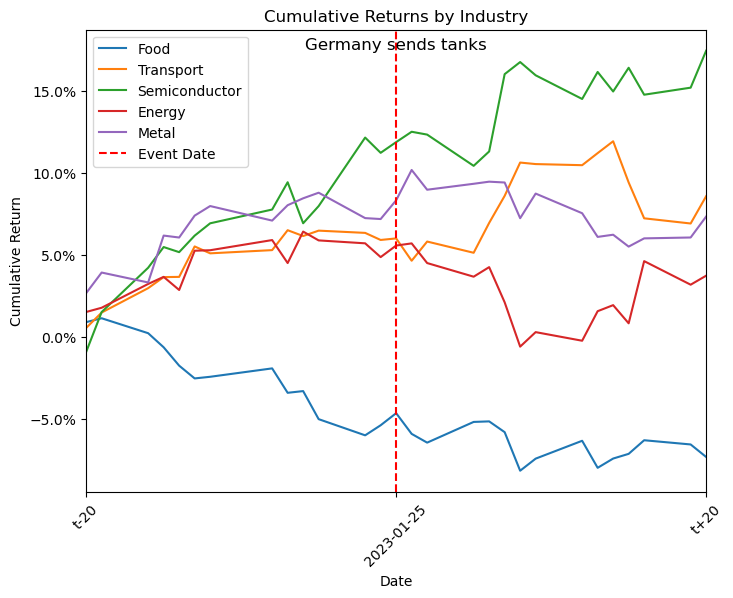

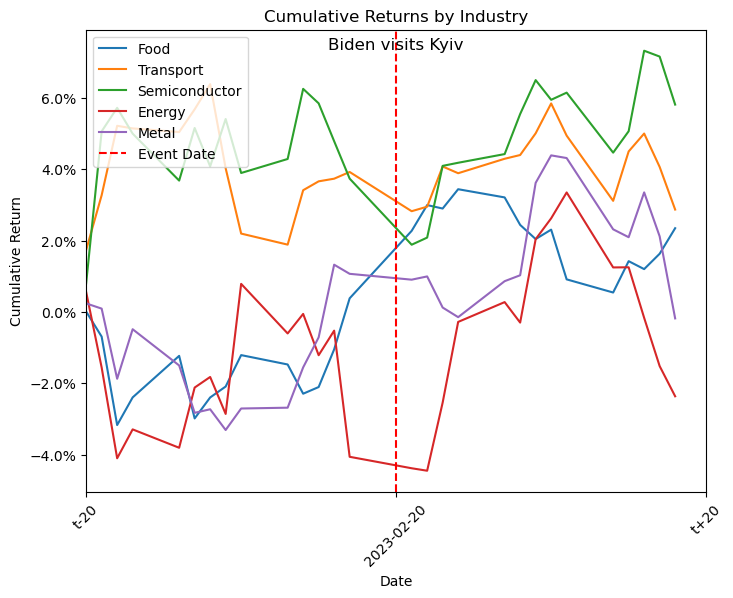

In [5]:
industries = ['Food', 'Transport', 'Semiconductor', 'Energy', 'Metal']
for index, row in event_dates.iterrows():
    event = row['Event']
    date = row['Date']
    
    sub_df = event_ret_df.query("Event == @event")
    
    plt.figure(figsize=(8, 6))
    sns.lineplot(x='Date', y='Cum_ret', data=sub_df, hue="Industry")
    
    plt.axvline(date, color='red', linestyle='--', label='Event Date')
    plt.xlim(date - pd.Timedelta(days=20), date + pd.Timedelta(days=20))
    
    xticks = [date - pd.Timedelta(days=20), date, date + pd.Timedelta(days=20)]
    xticklabels = ['t-20', date.strftime('%Y-%m-%d'), 't+20']
    plt.xticks(xticks, xticklabels)
    plt.xticks(rotation=45)
    
    plt.title('Cumulative Returns by Industry')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    
    ymin, ymax = plt.ylim()
    y_pos = ymax - (ymax - ymin) * 0.05

    # add text to plot
    plt.text(date, y_pos, event, fontsize=12,
             ha='center', va='bottom')

    # move the legend to the bottom right corner
    plt.legend(loc='lower right')
    plt.legend(loc='upper left')
    
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # format y-axis as percentages

    # show the plot
    plt.show()

### Plotting Cumulative Returns For Every Event For Every Industry (cumulative returns by events for individual industries)

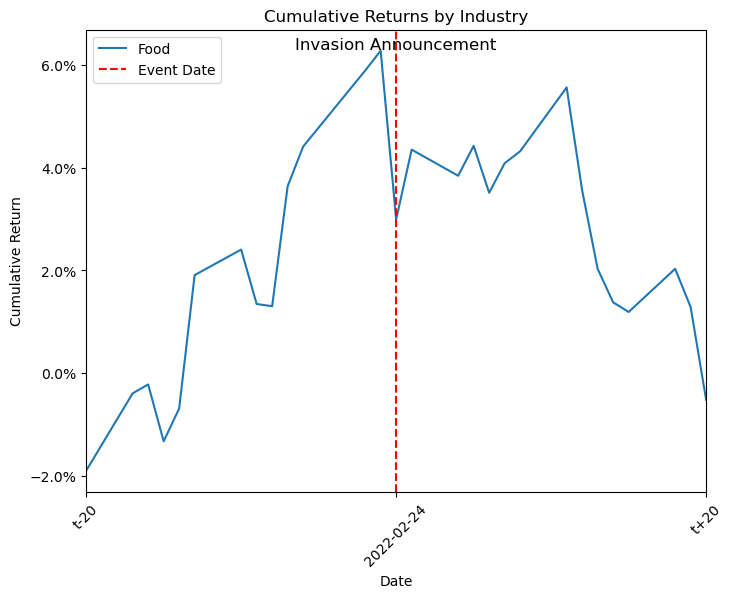

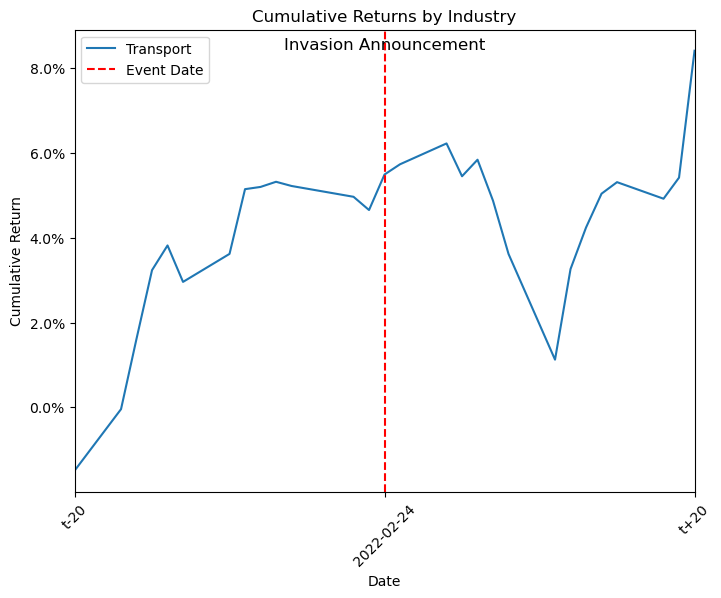

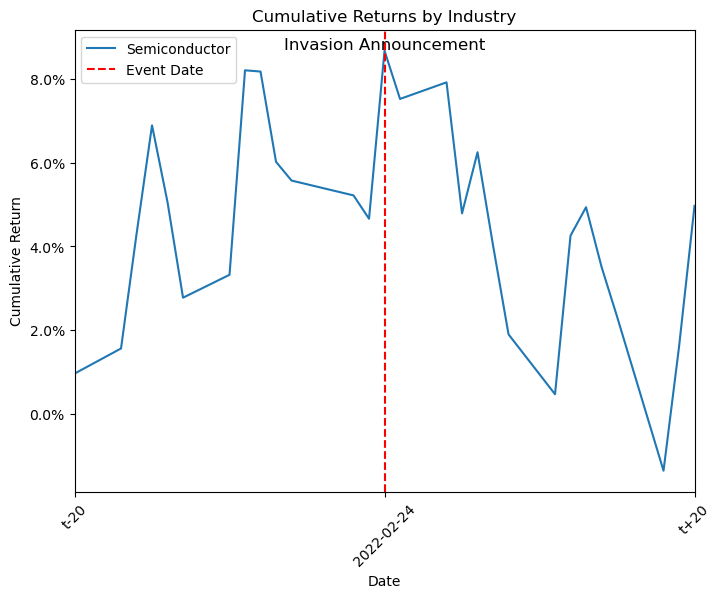

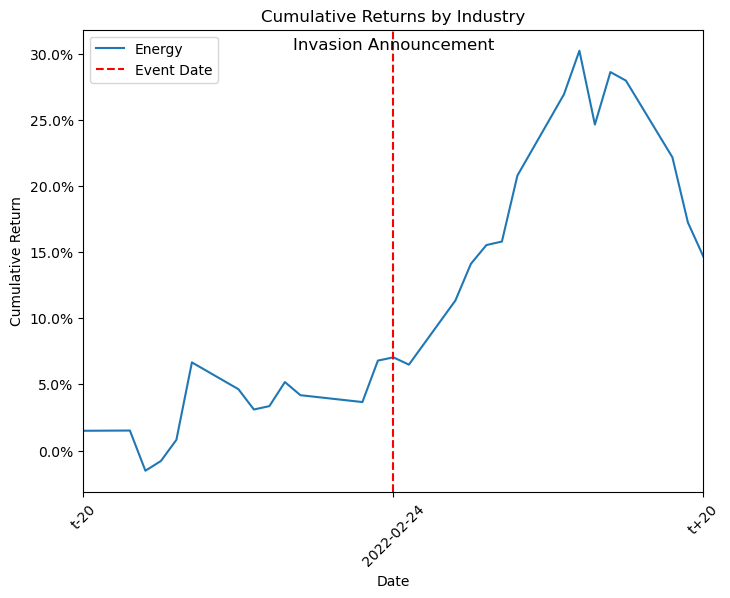

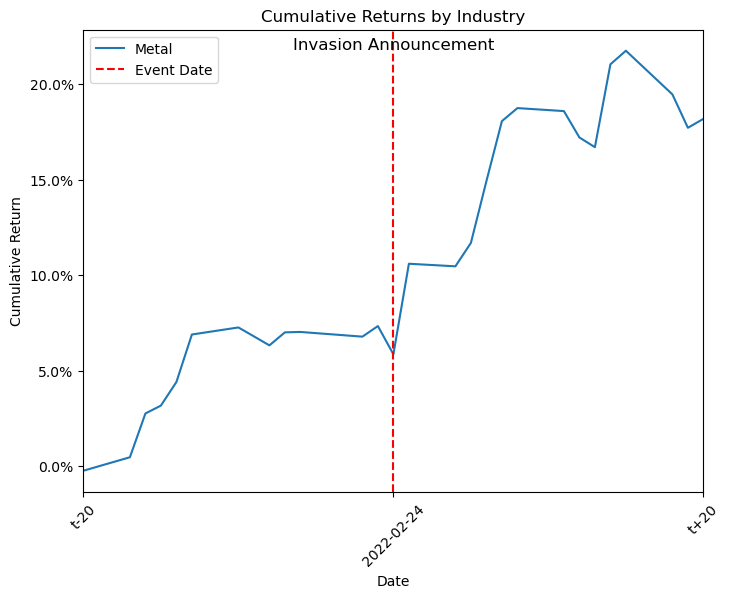

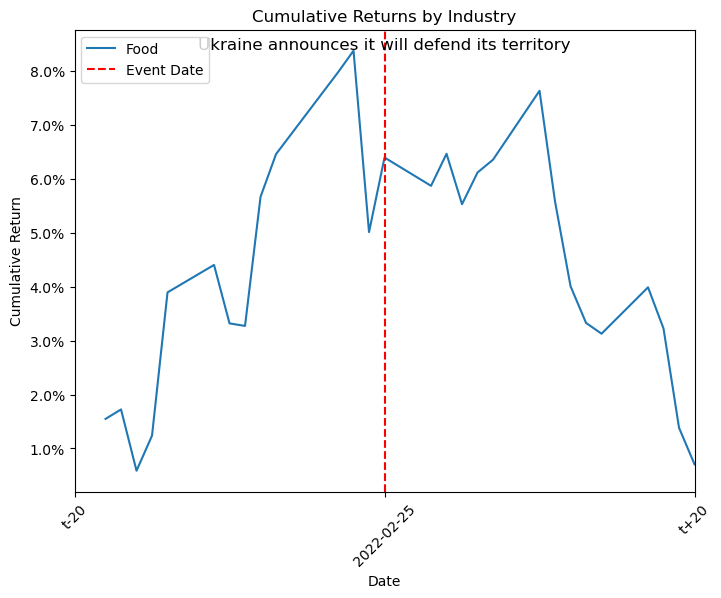

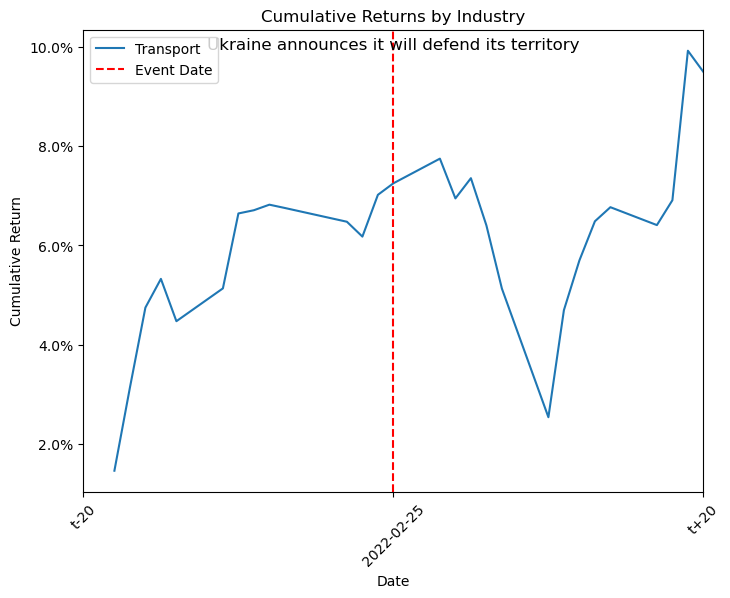

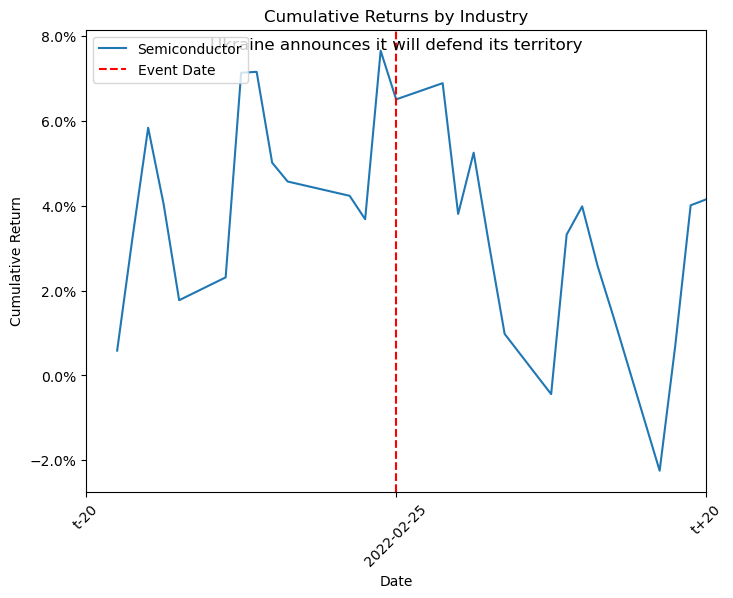

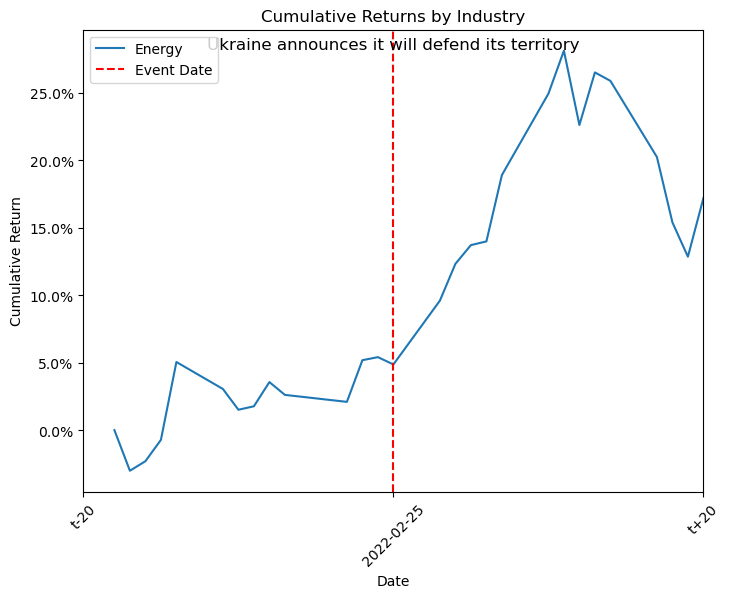

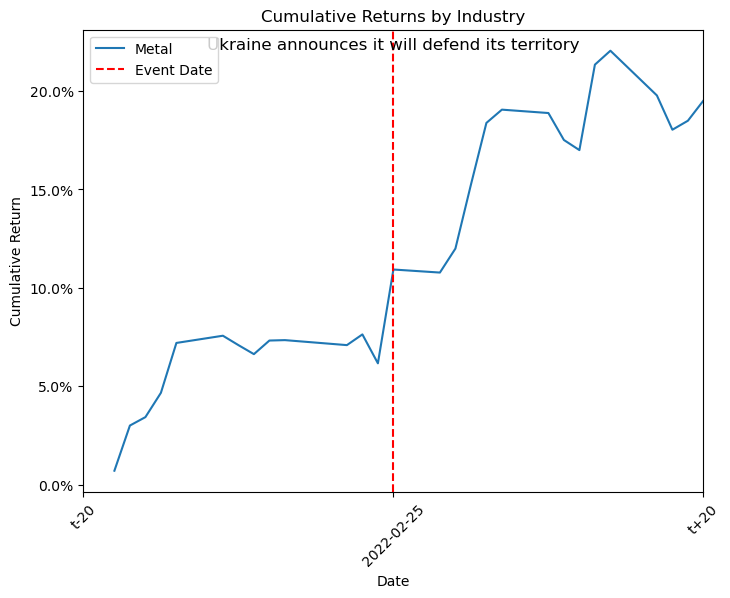

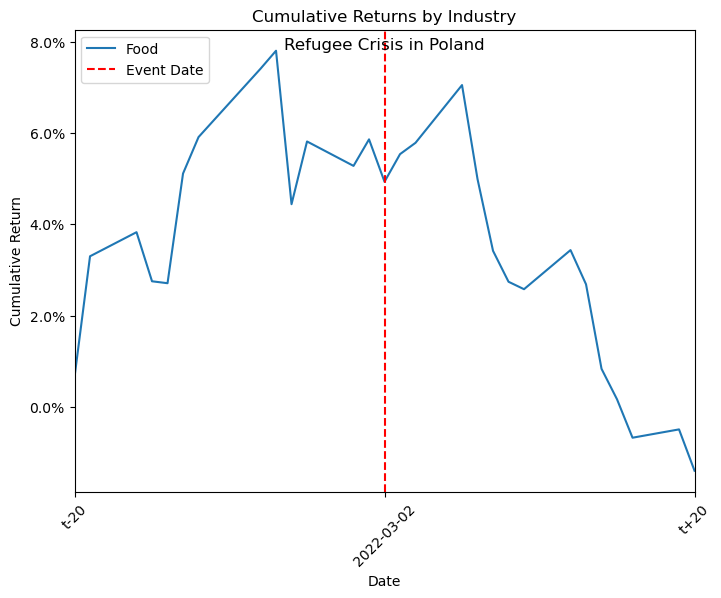

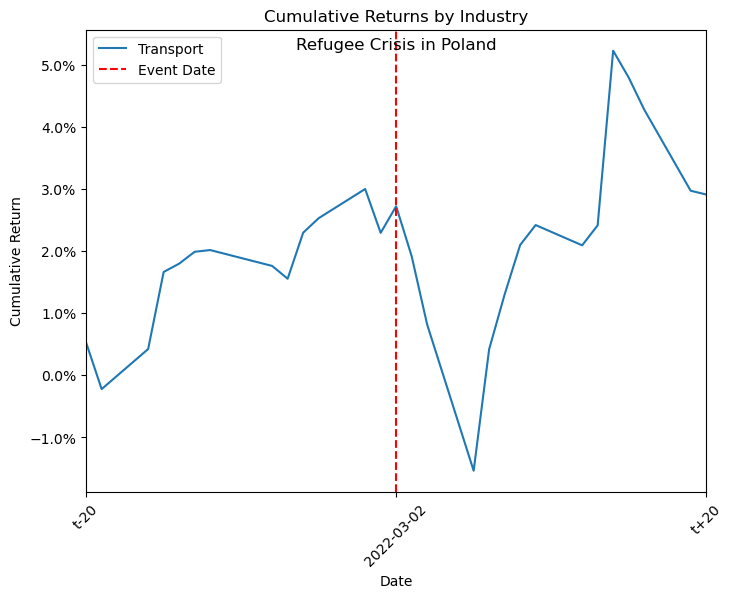

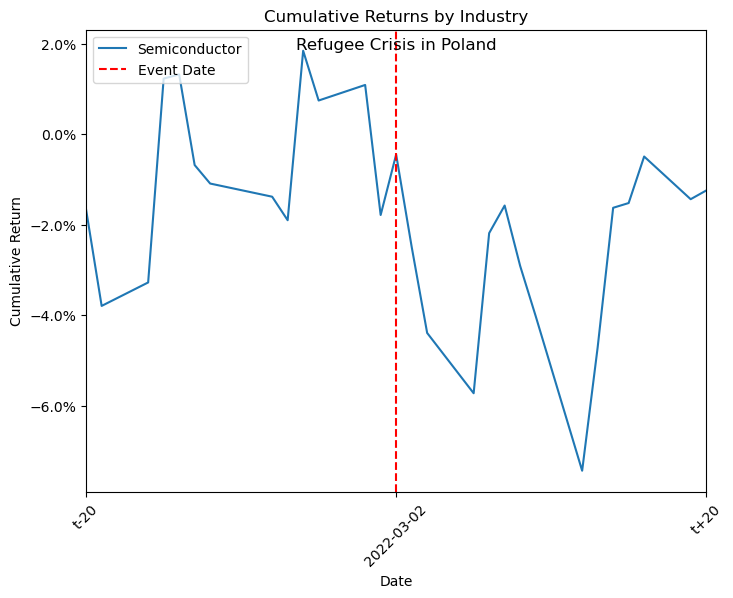

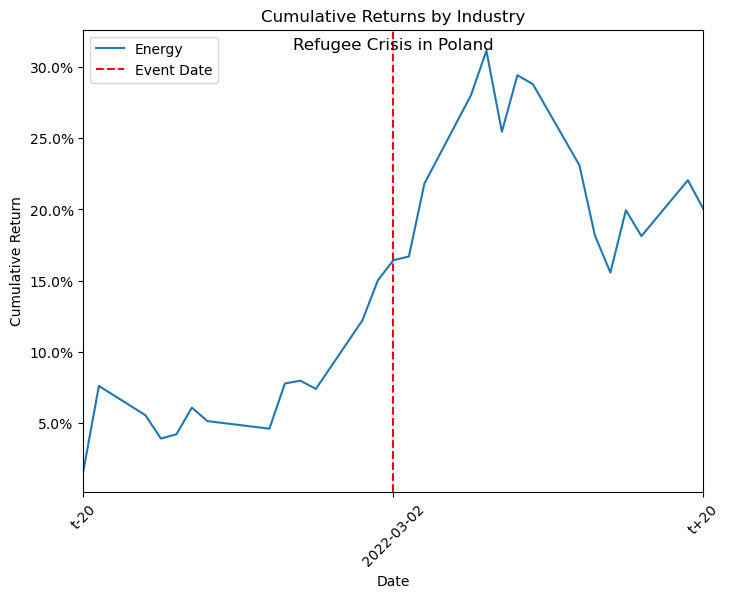

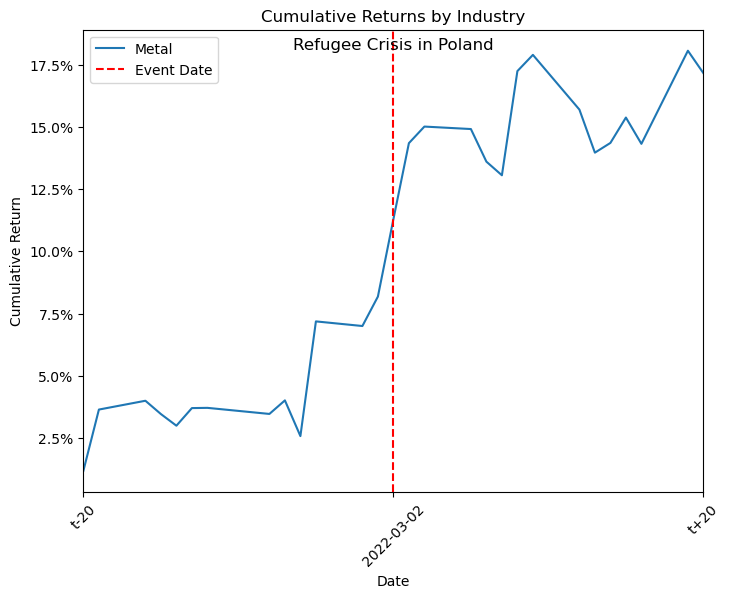

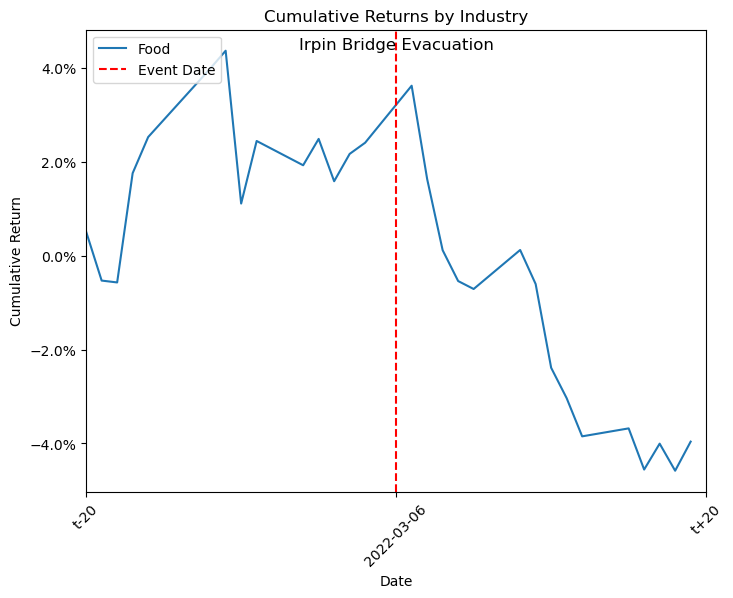

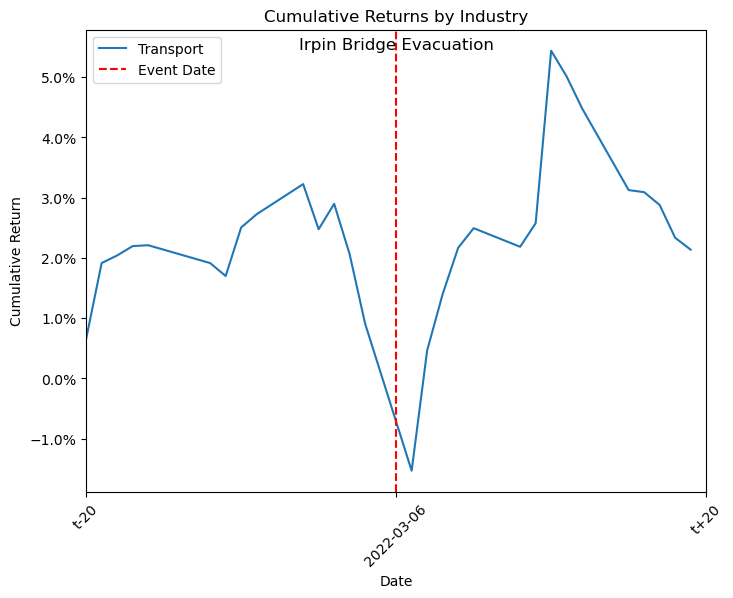

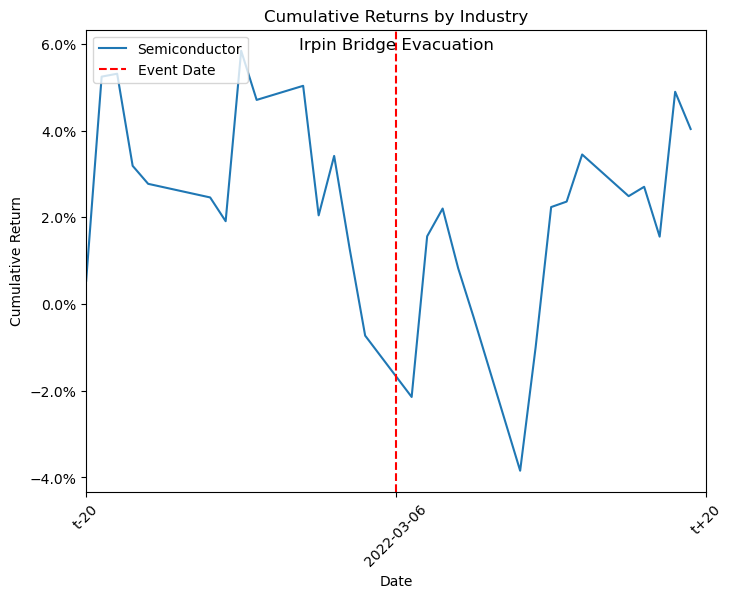

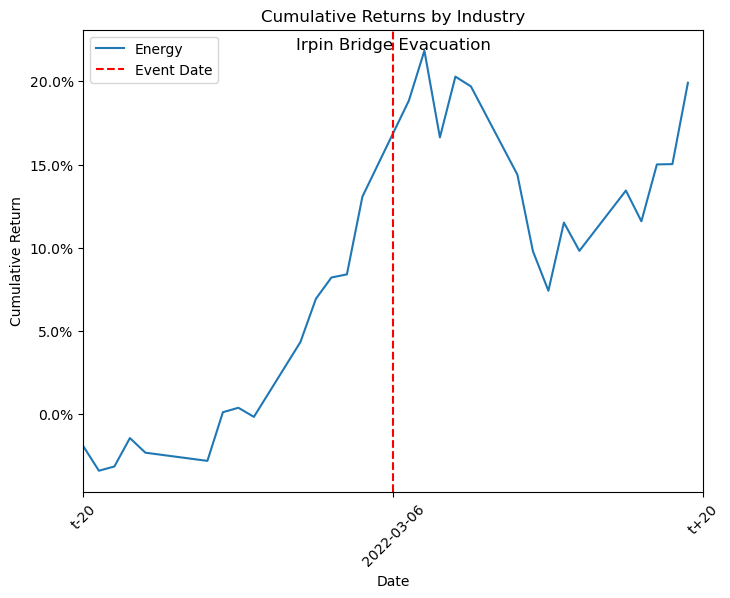

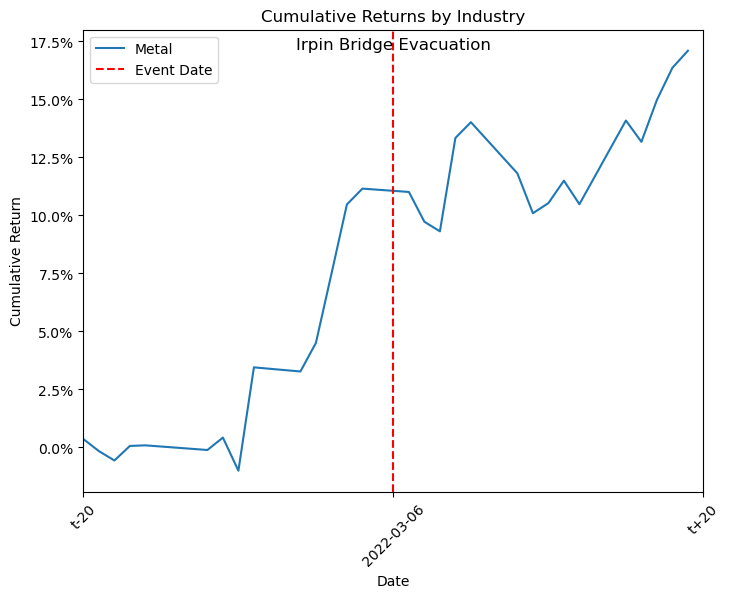

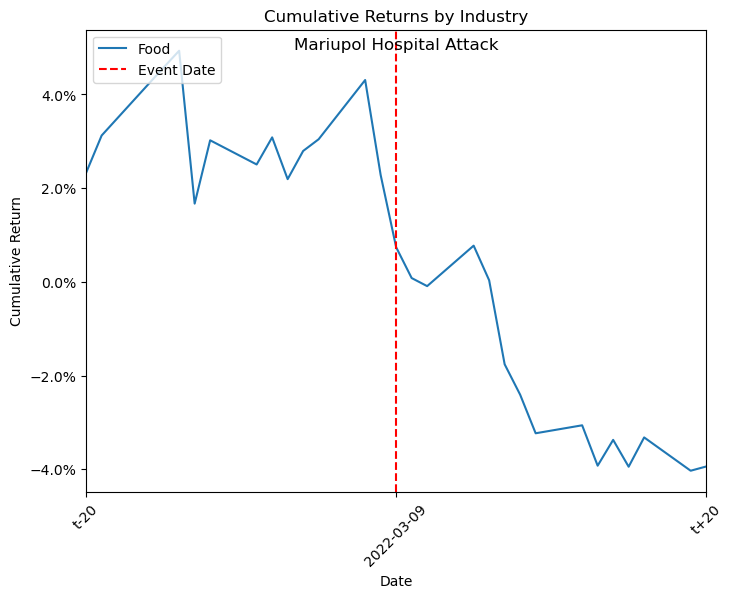

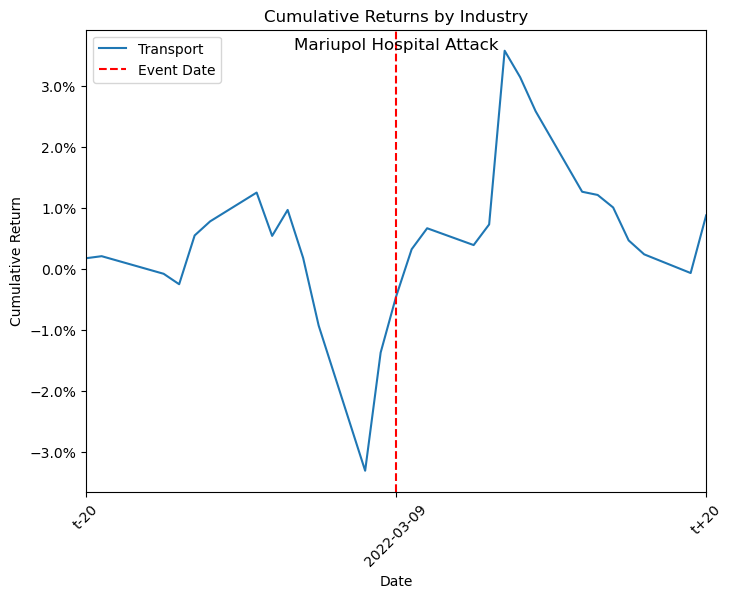

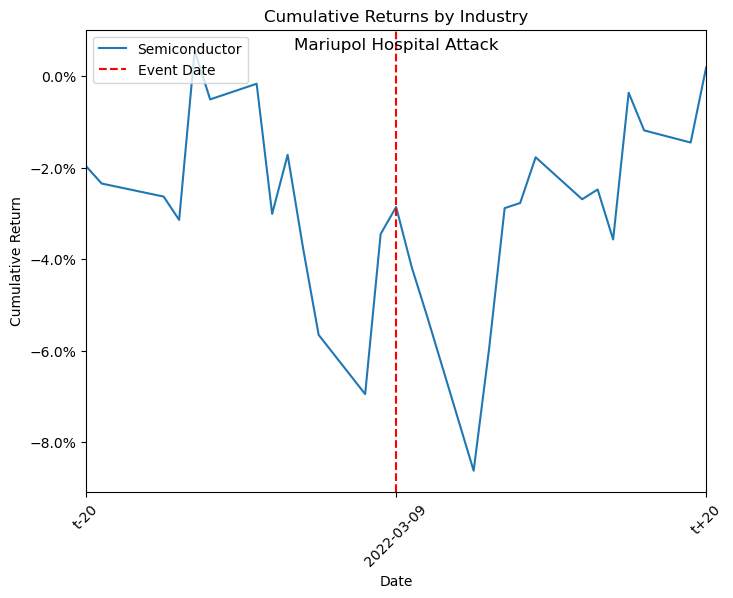

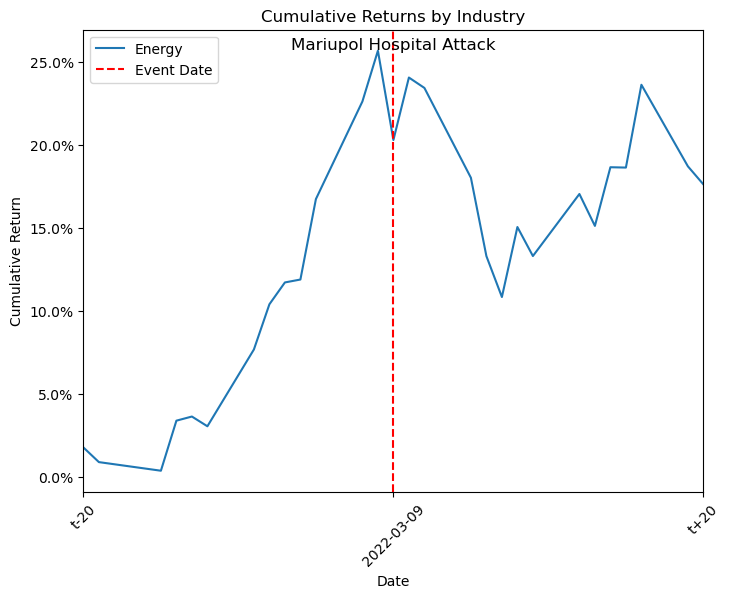

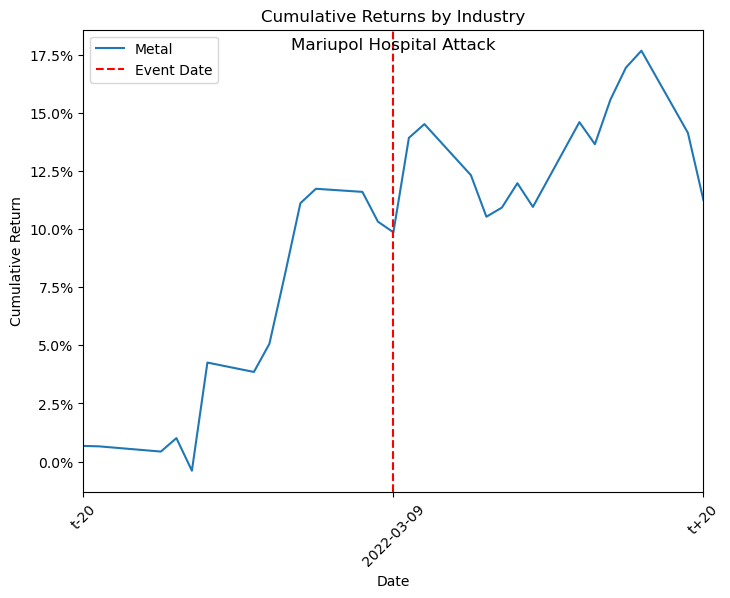

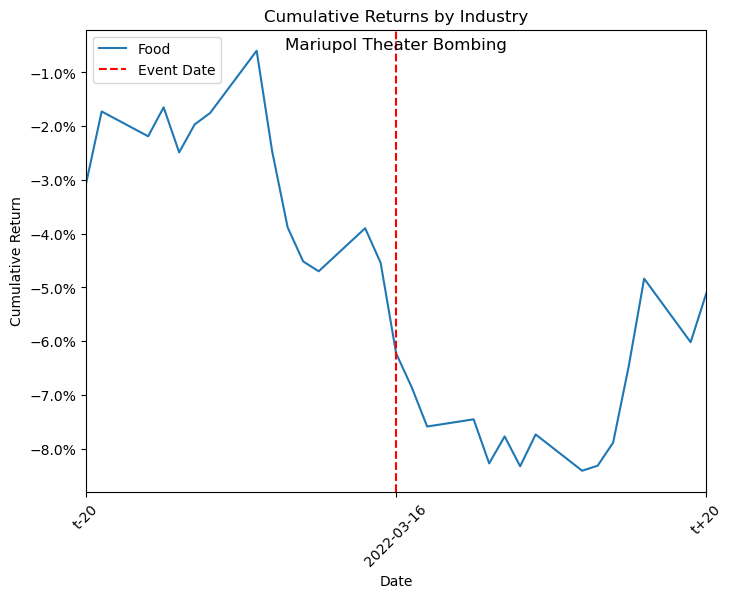

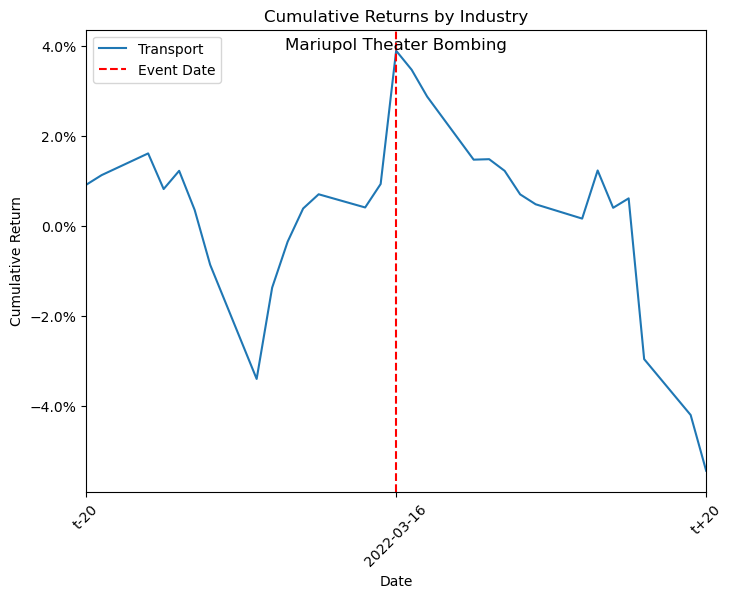

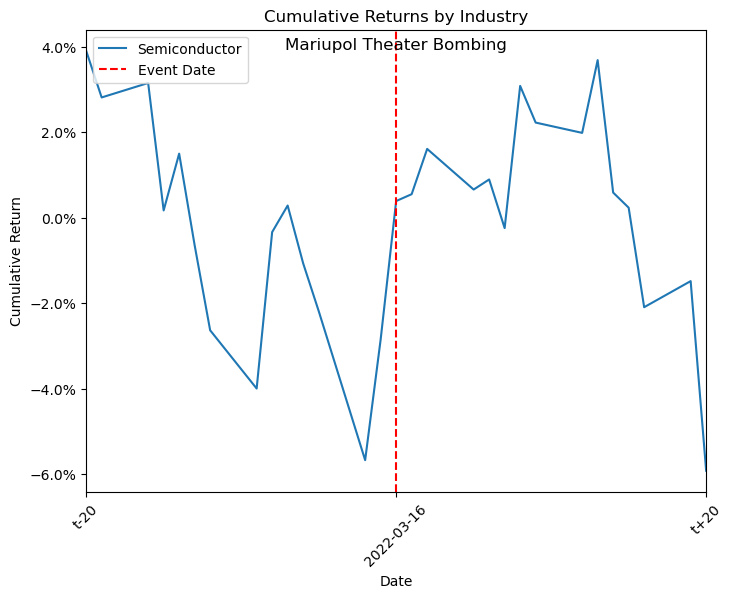

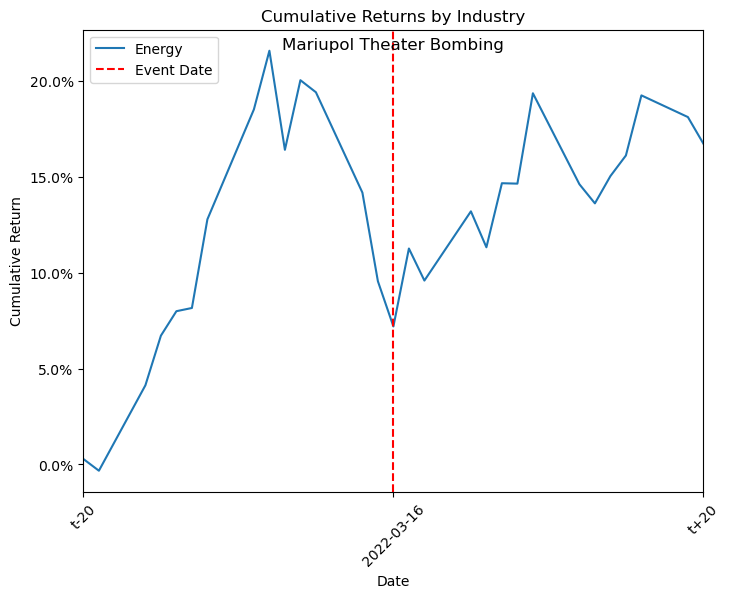

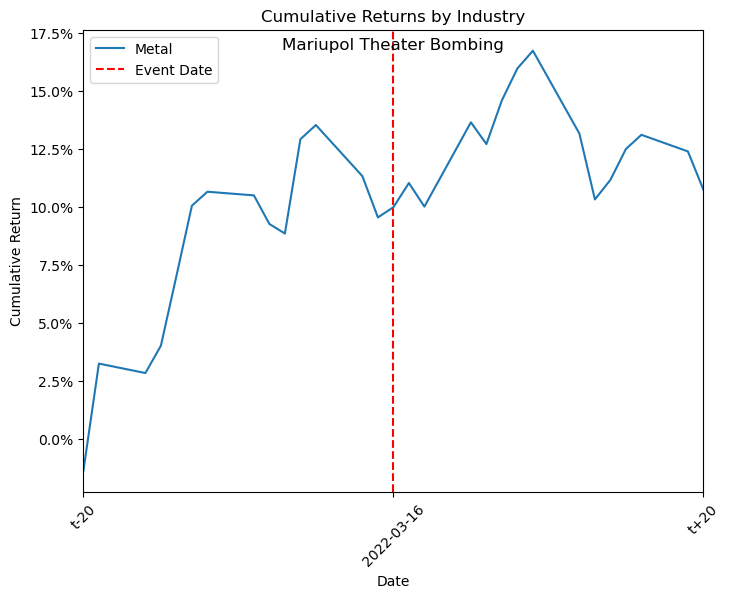

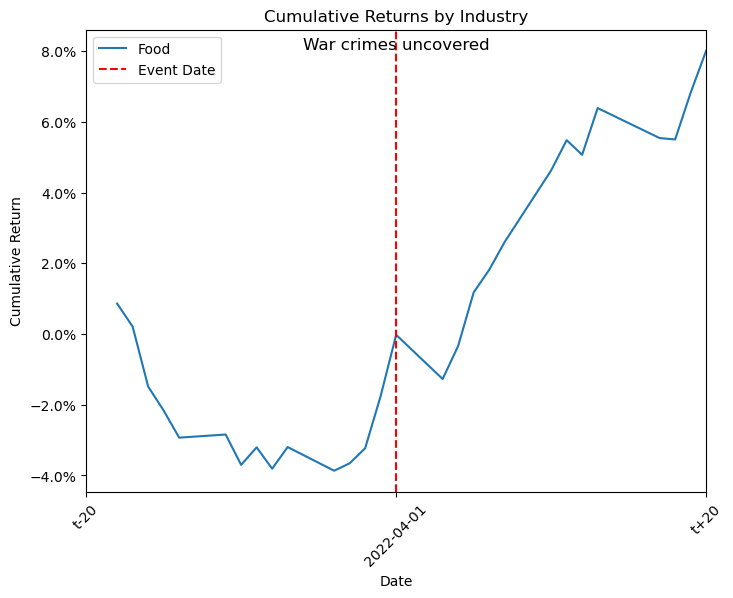

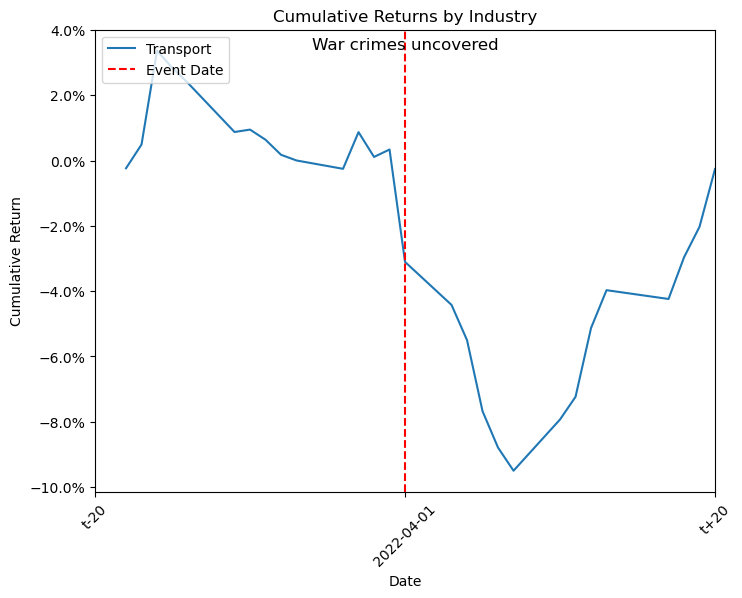

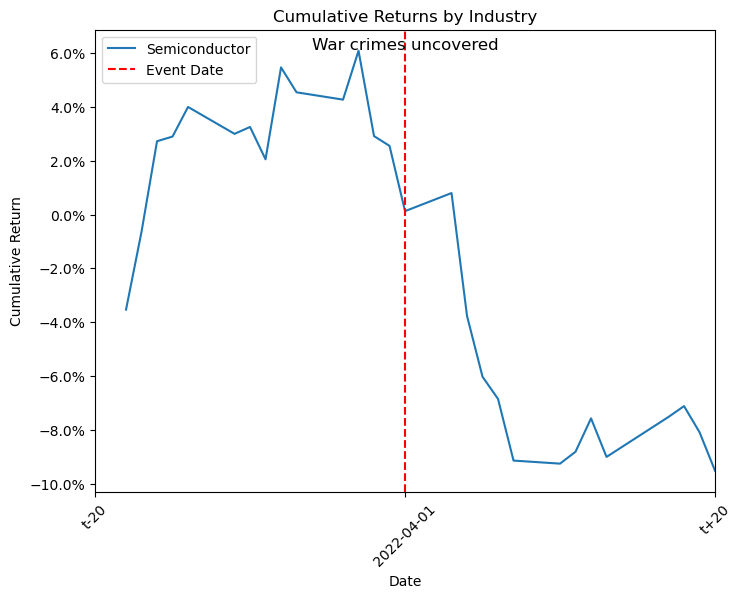

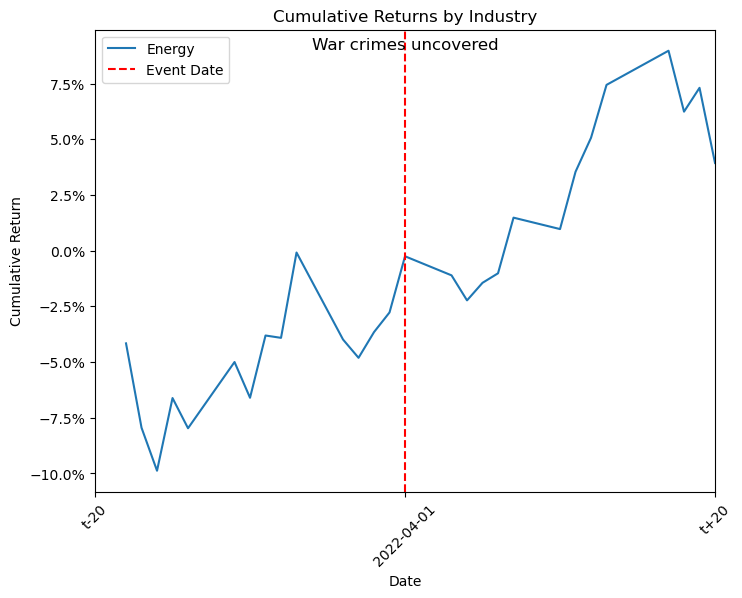

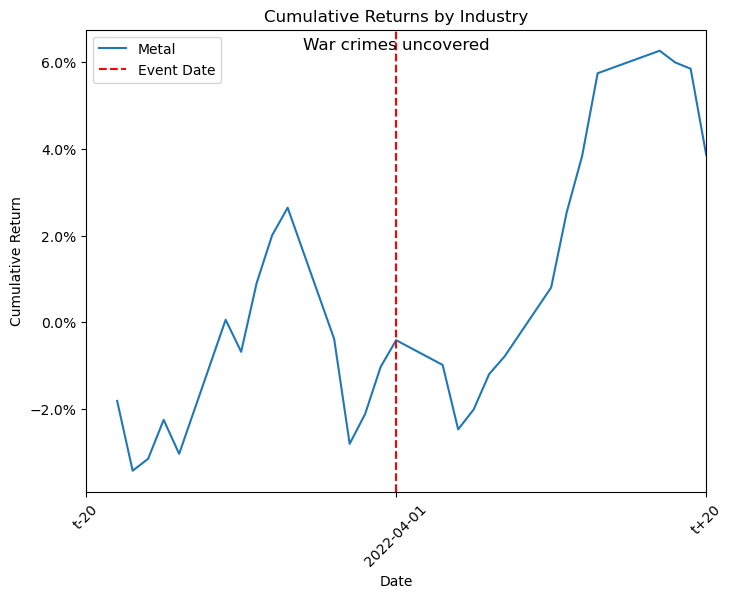

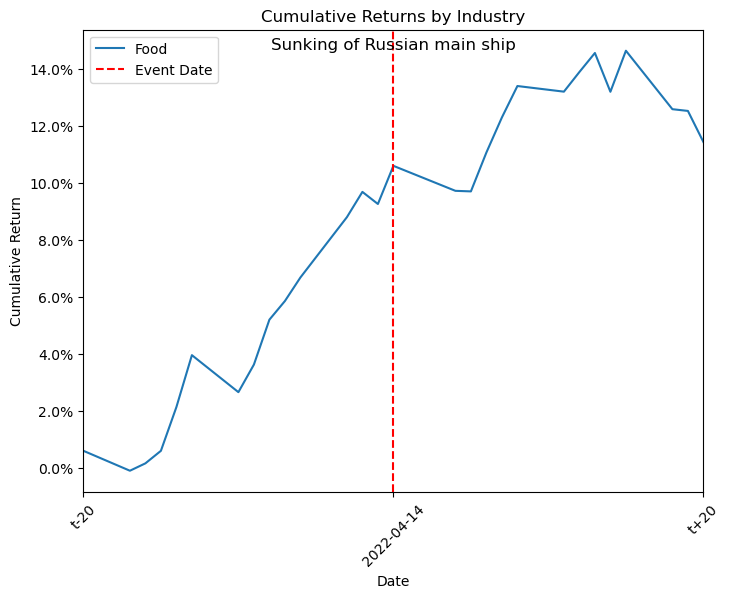

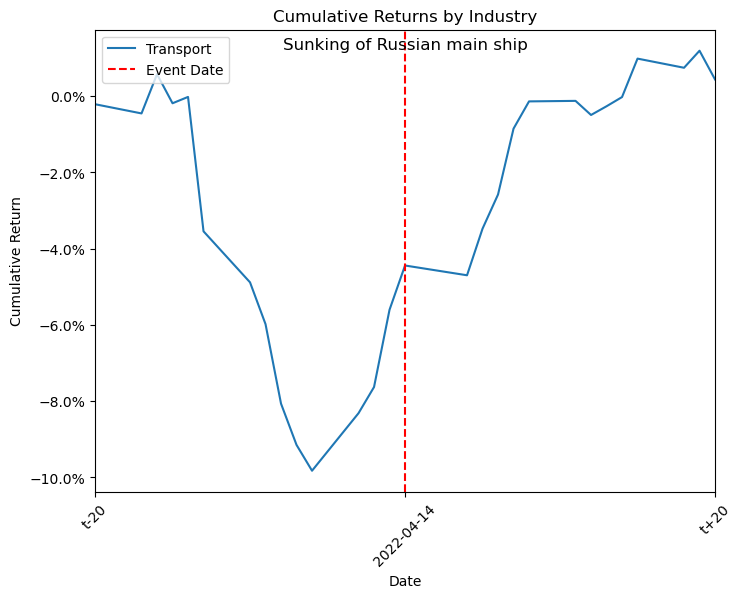

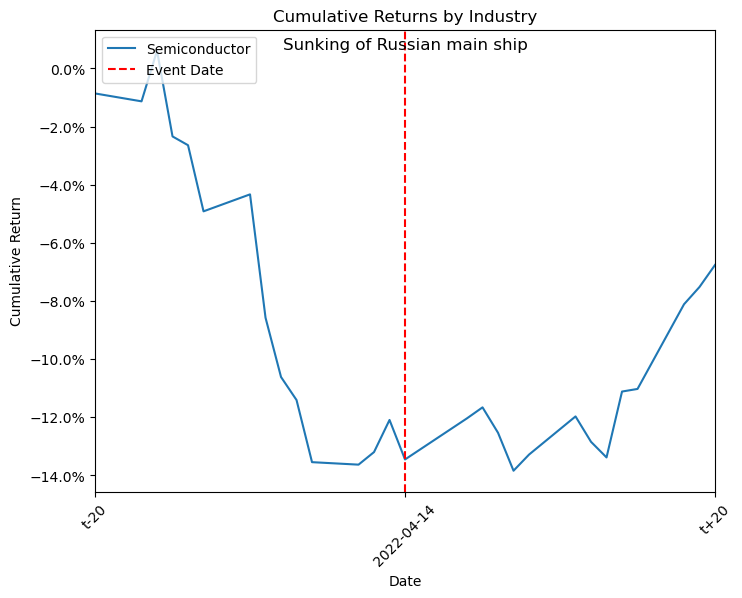

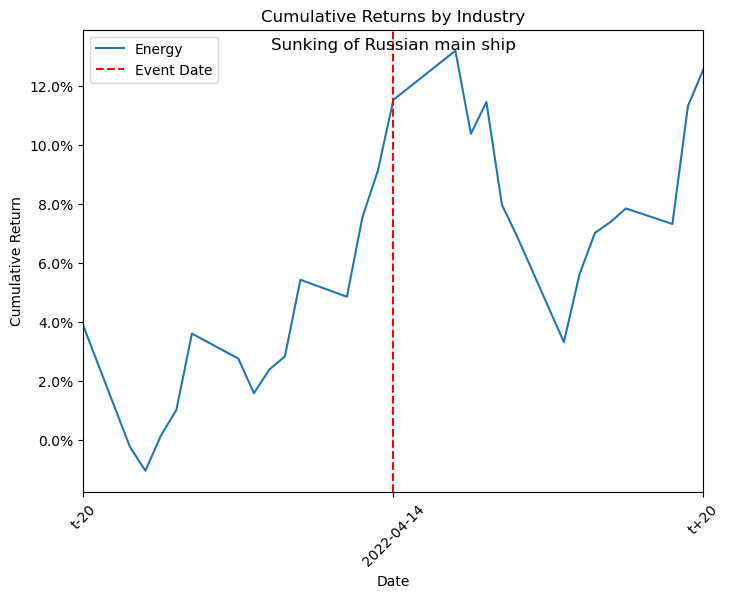

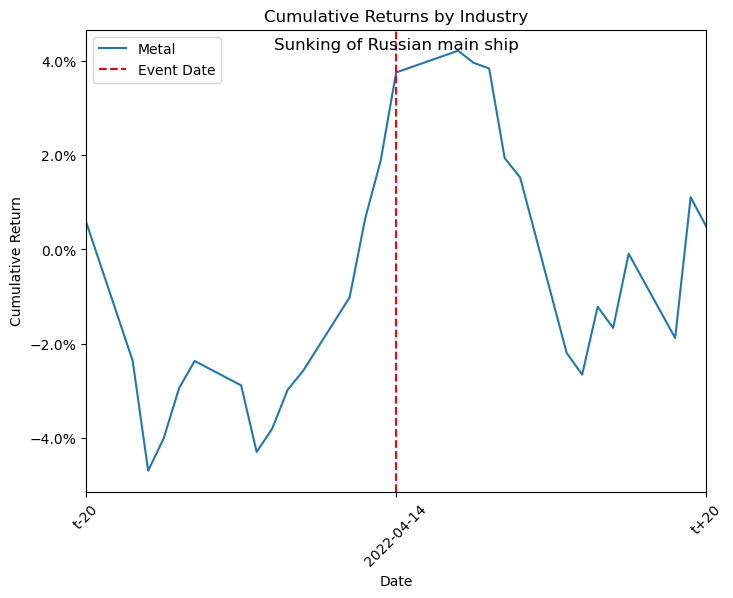

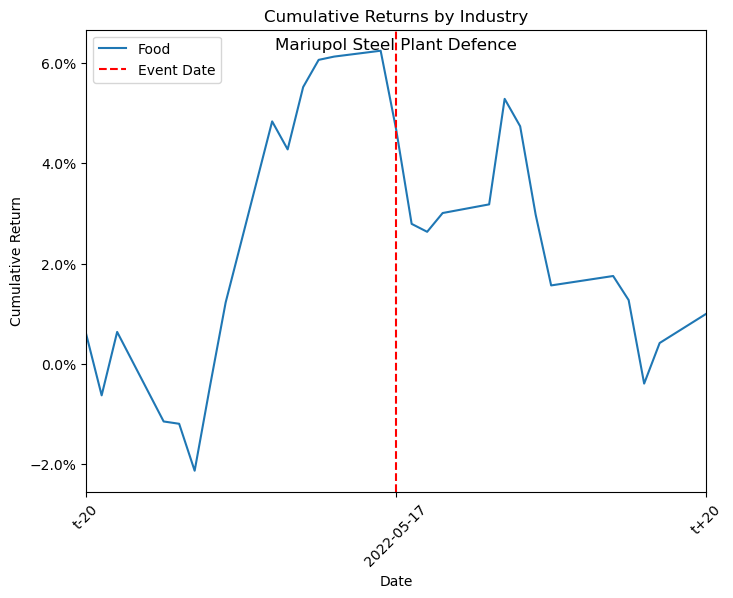

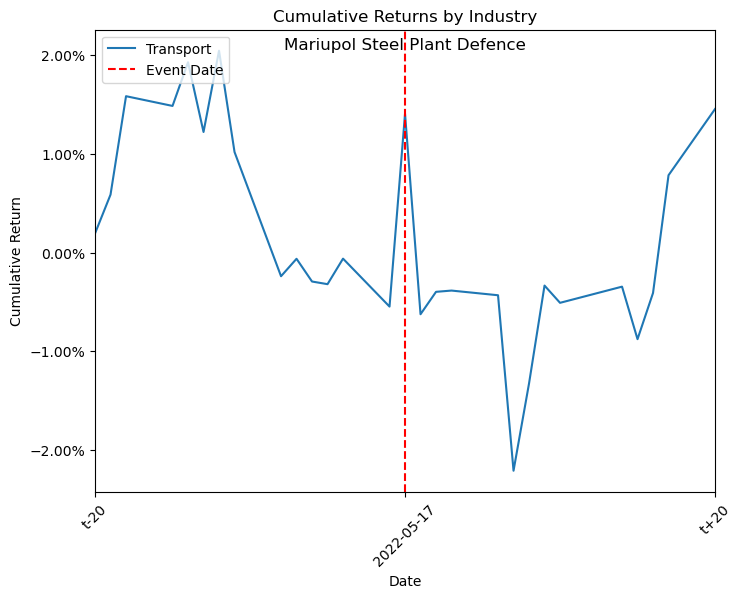

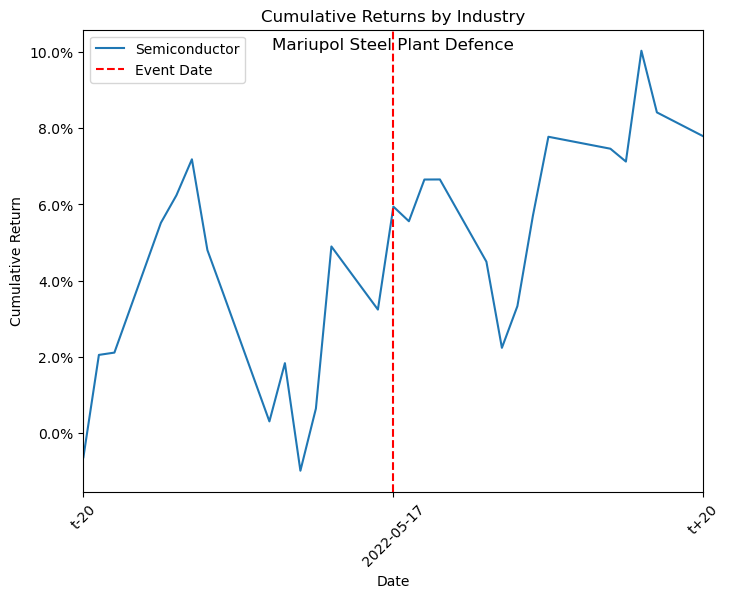

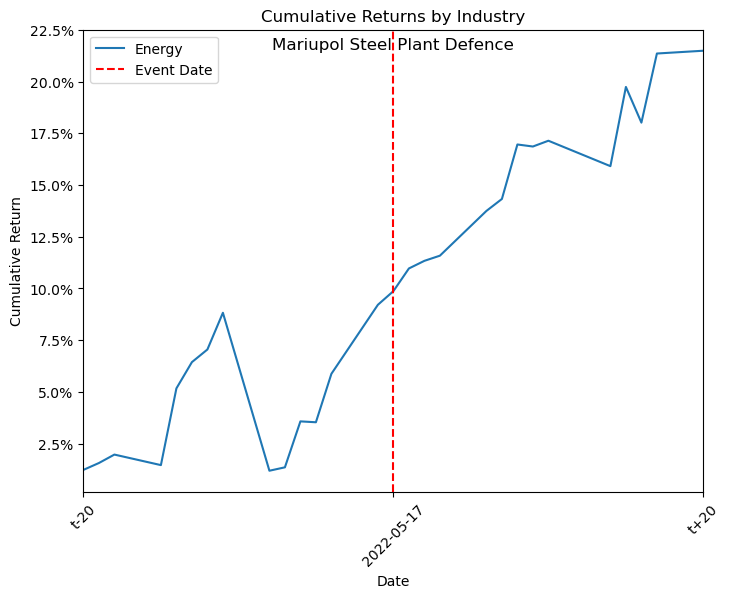

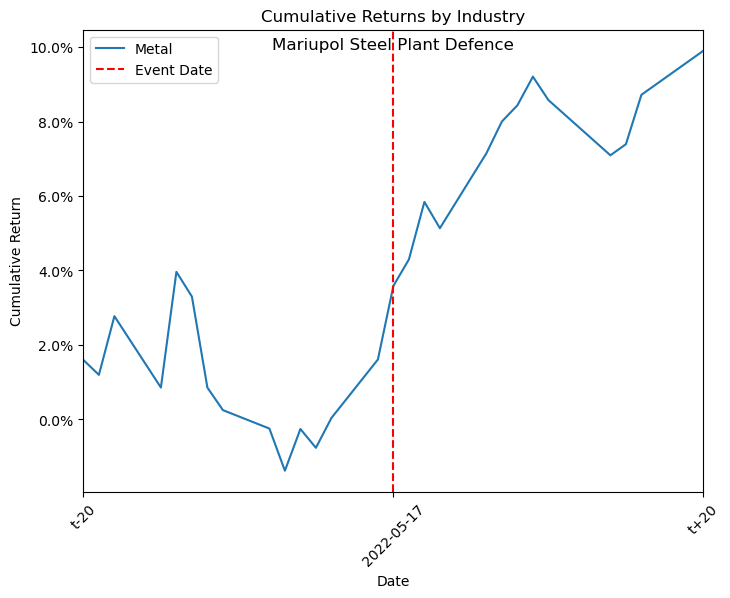

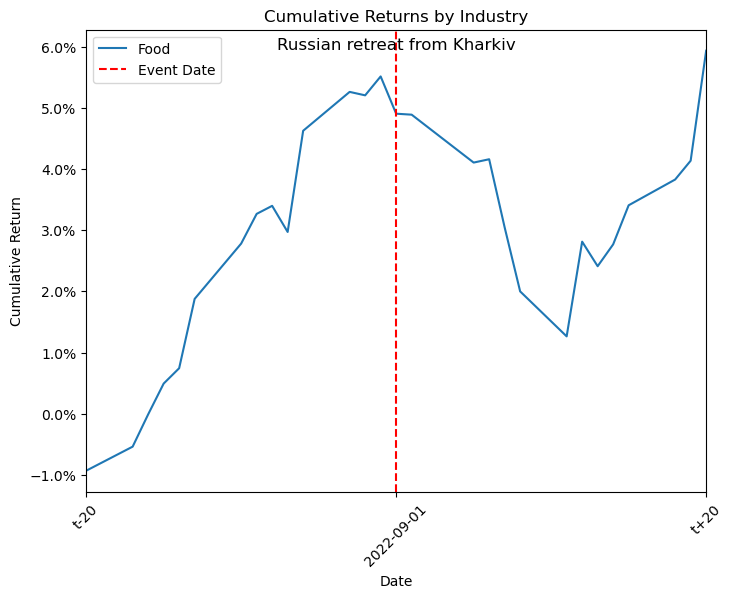

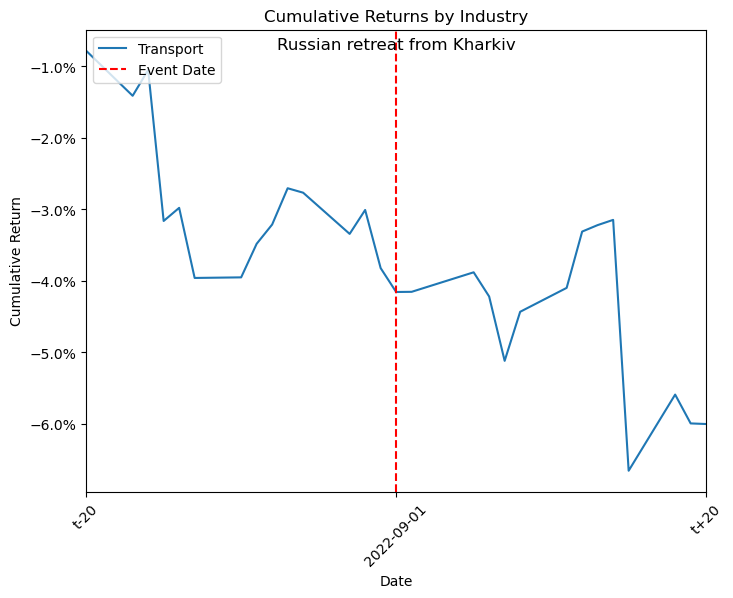

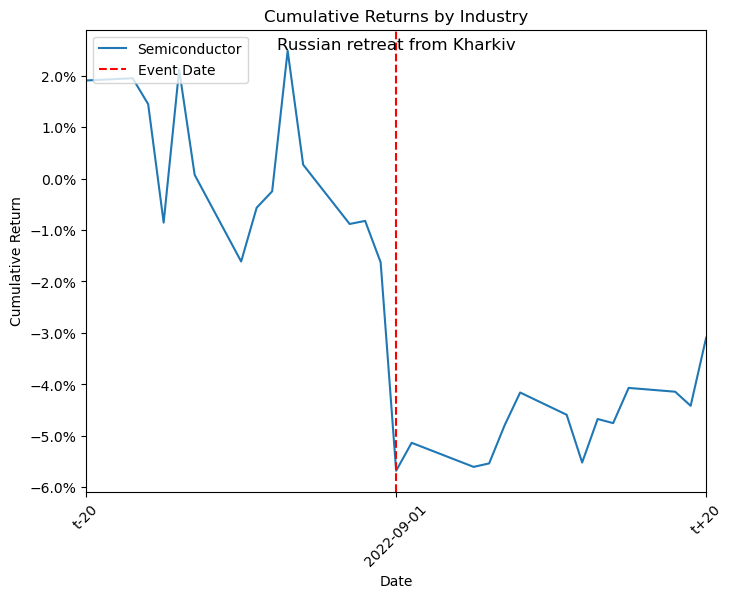

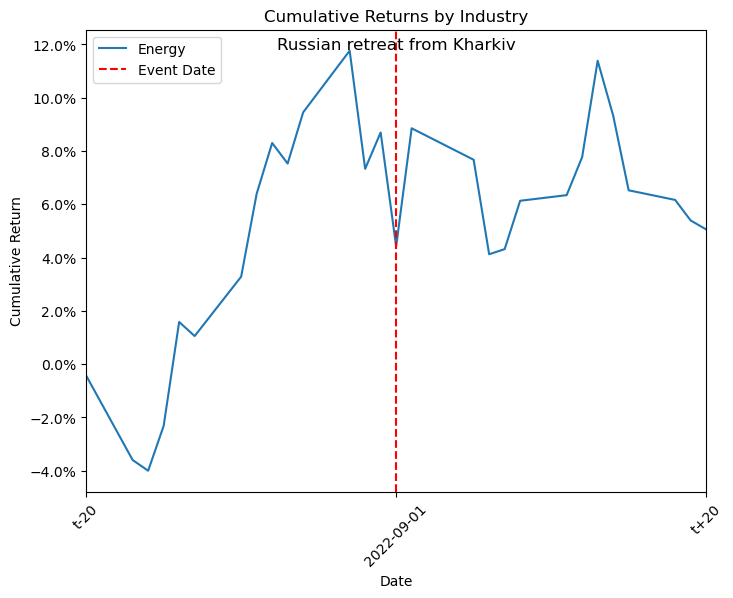

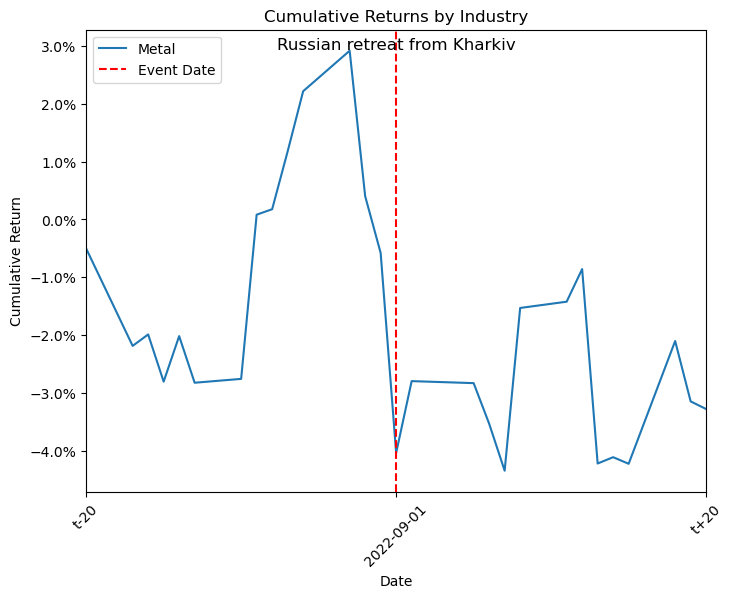

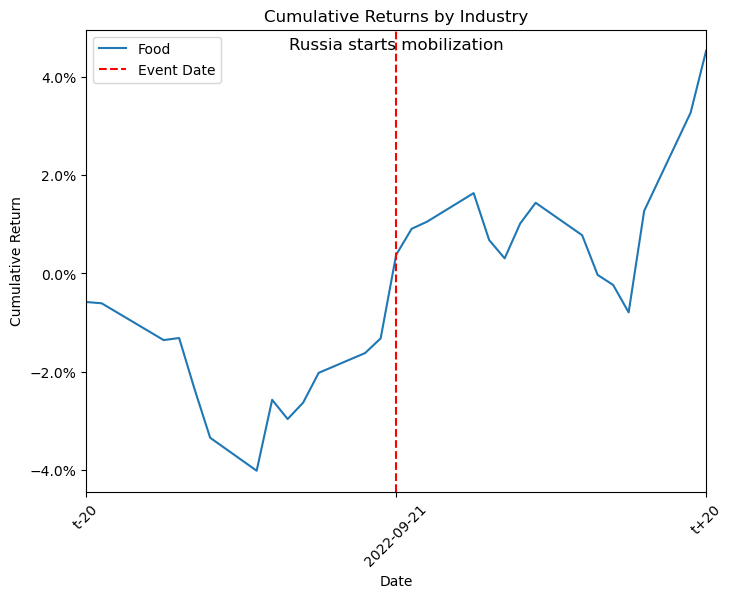

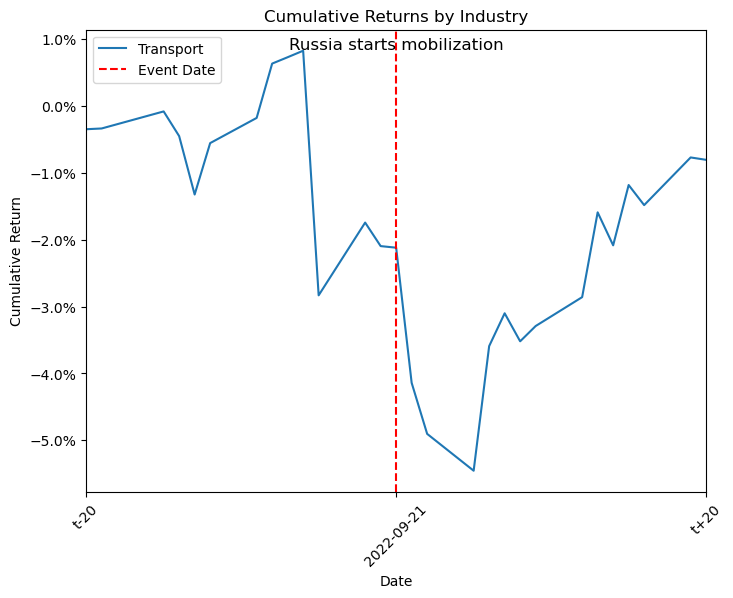

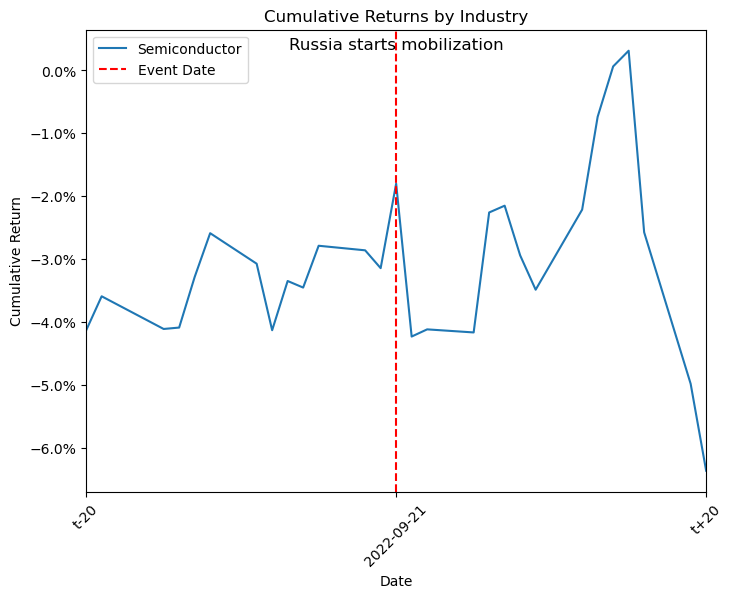

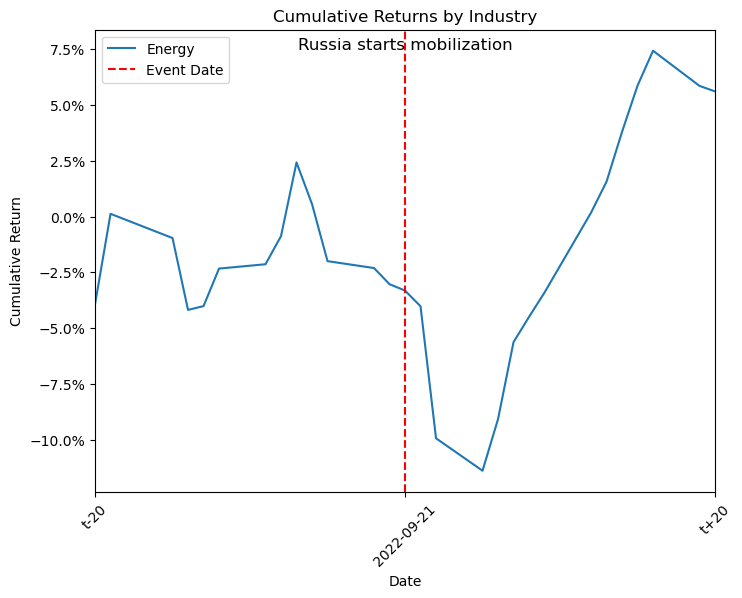

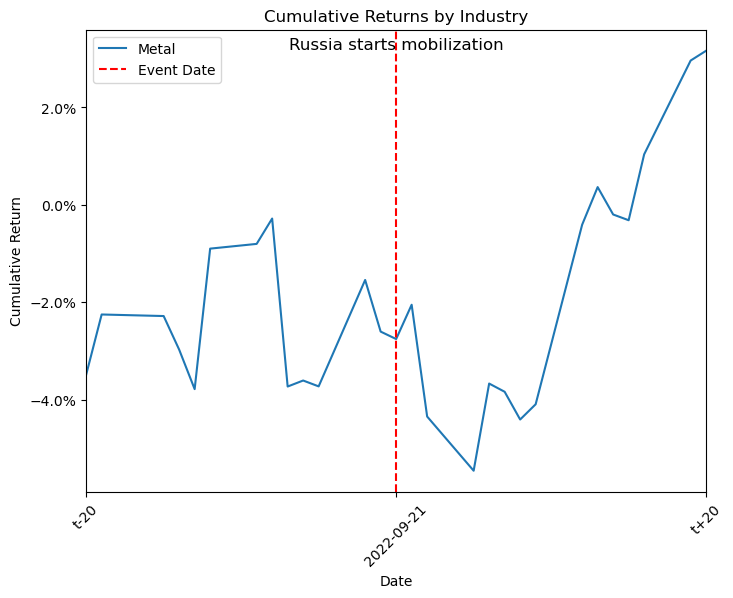

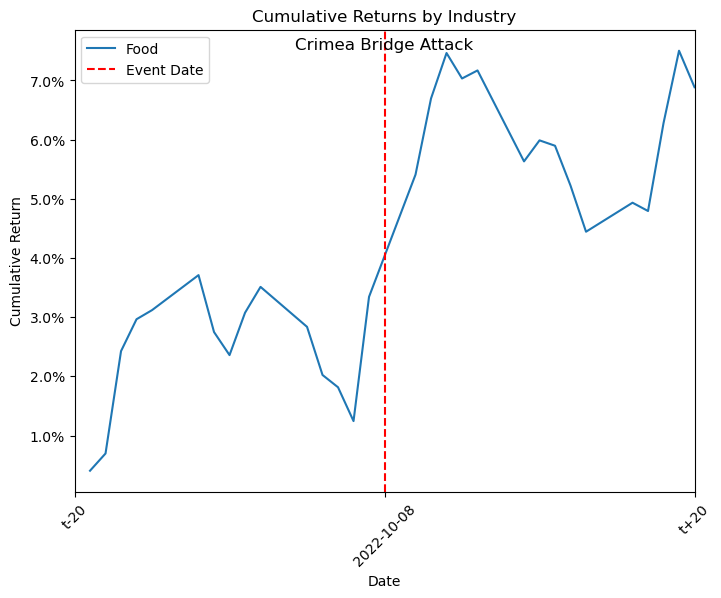

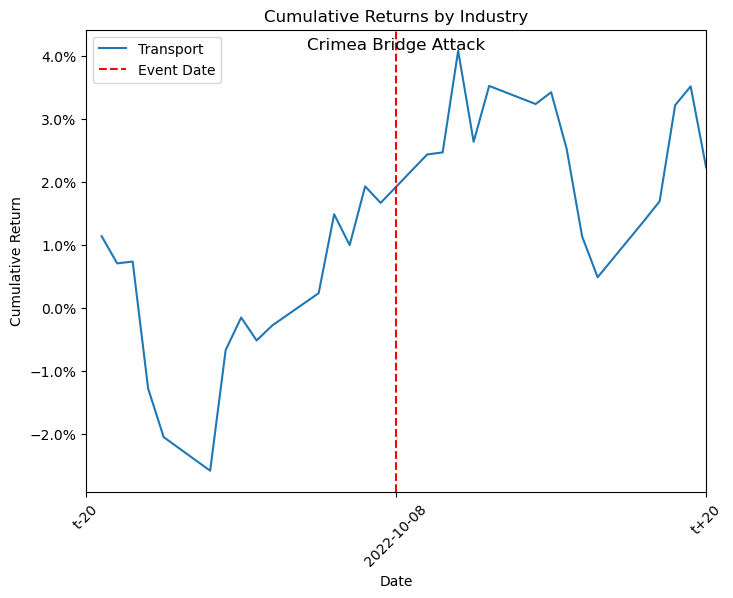

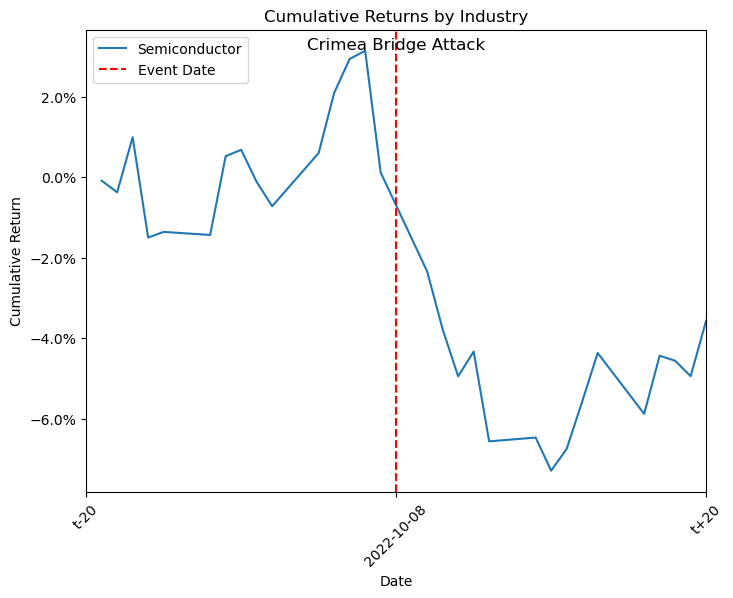

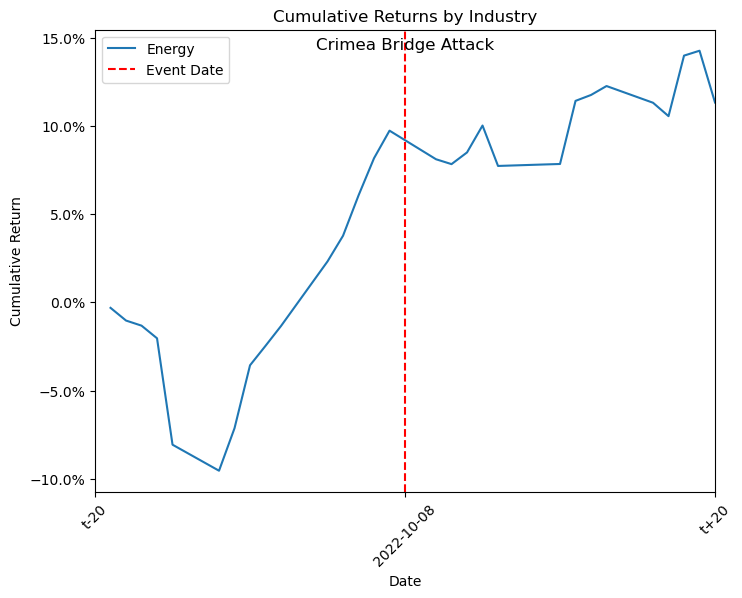

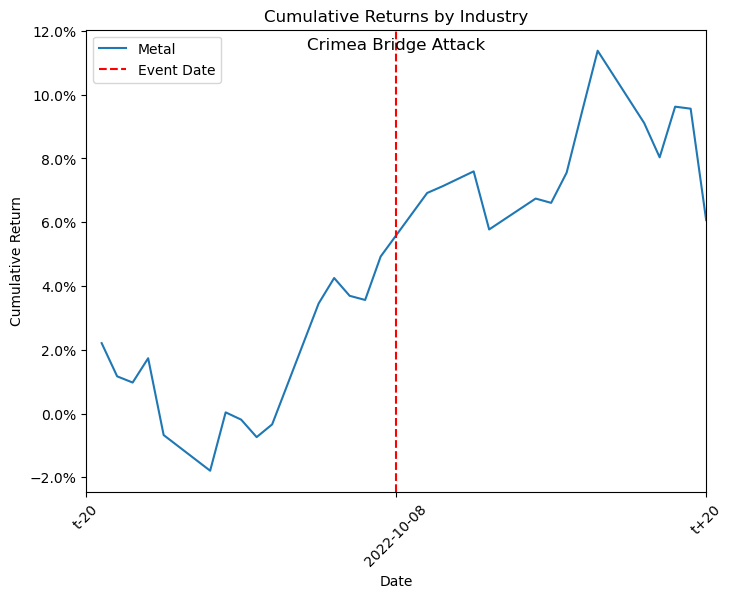

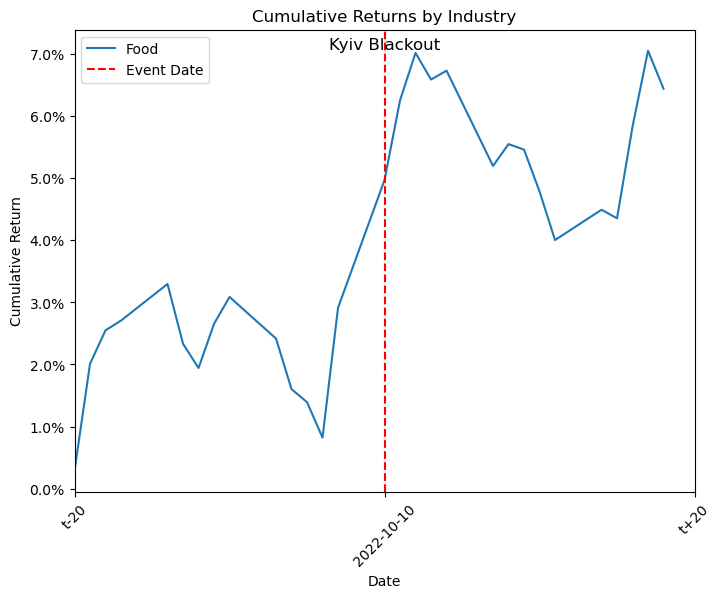

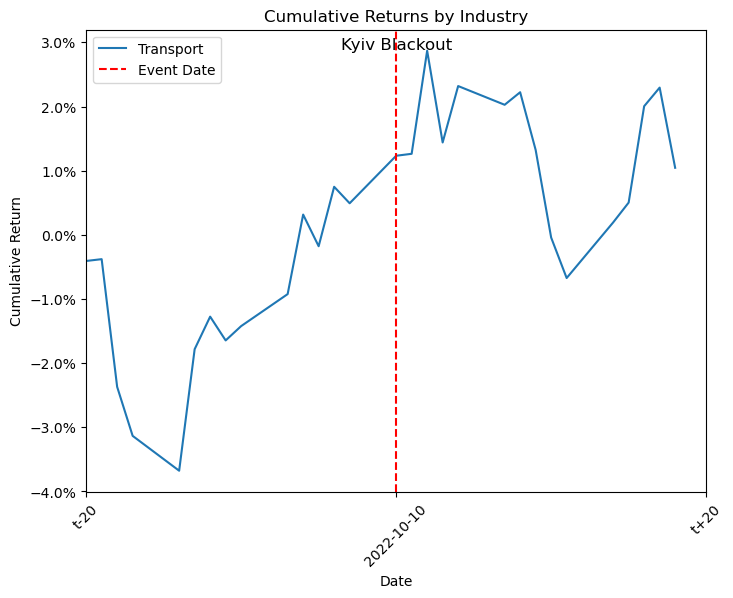

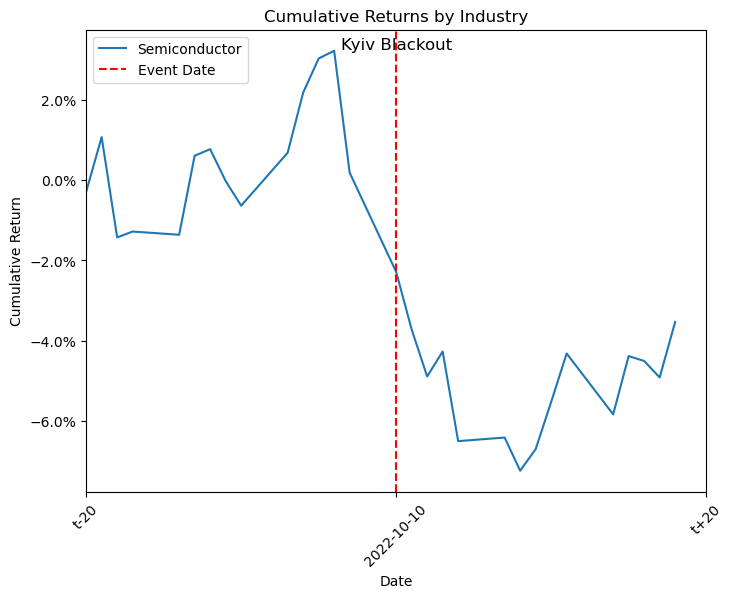

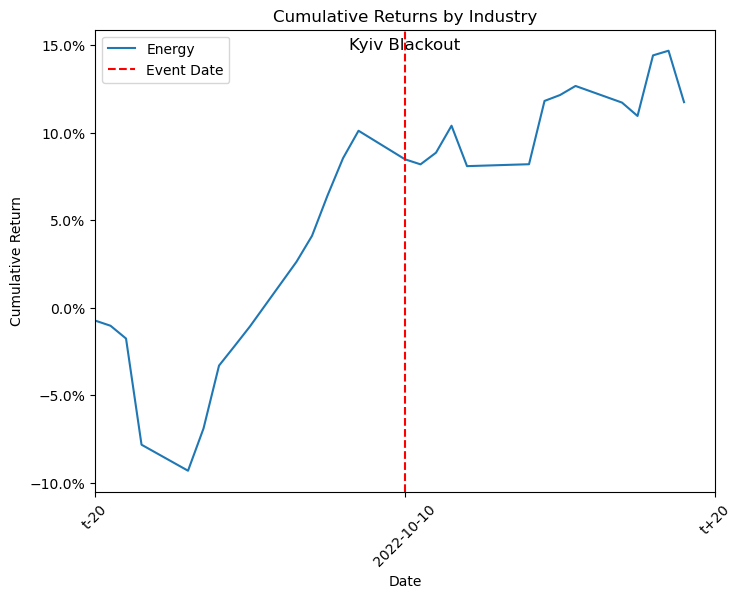

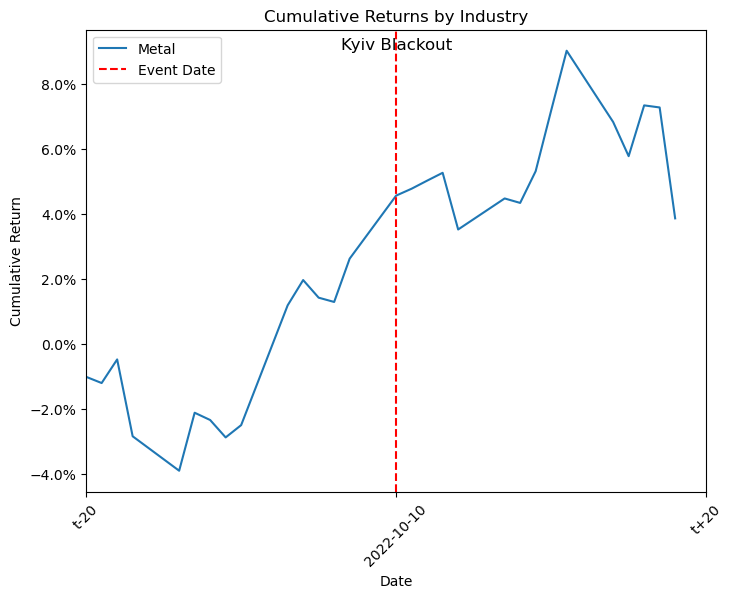

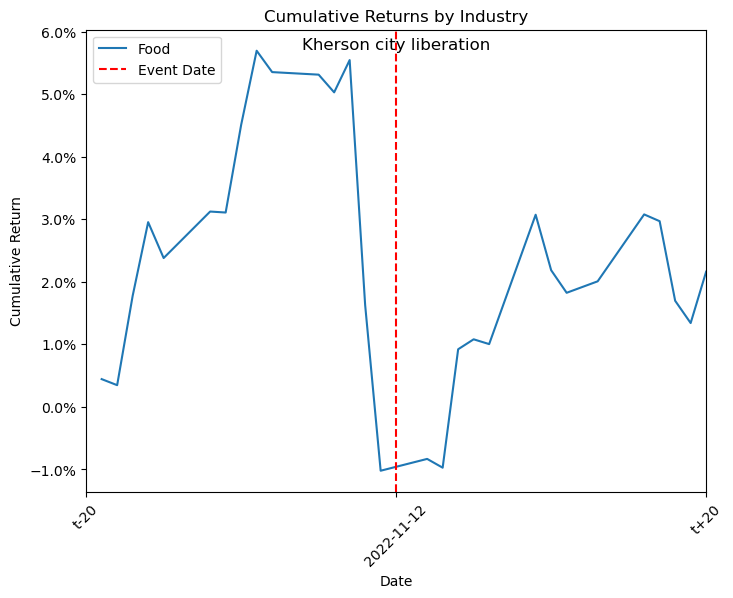

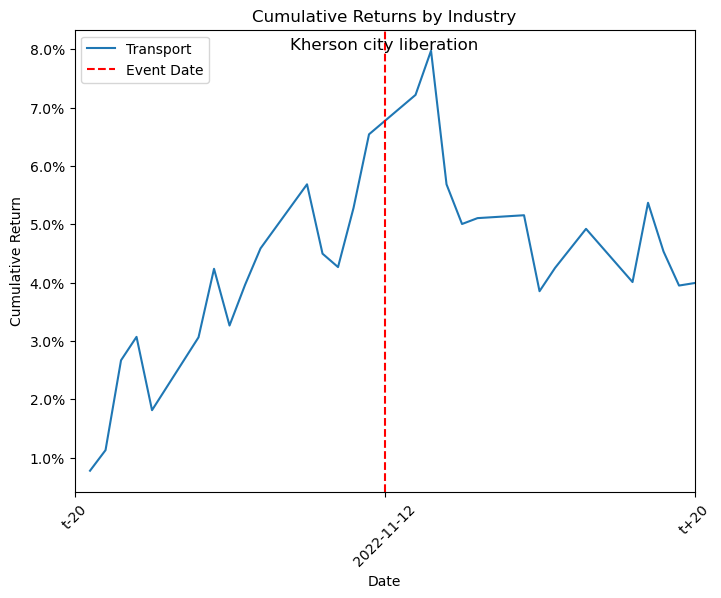

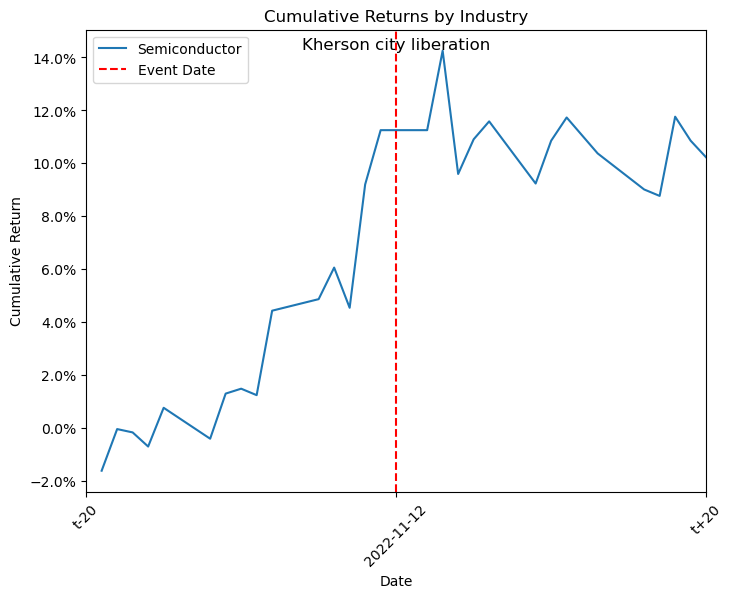

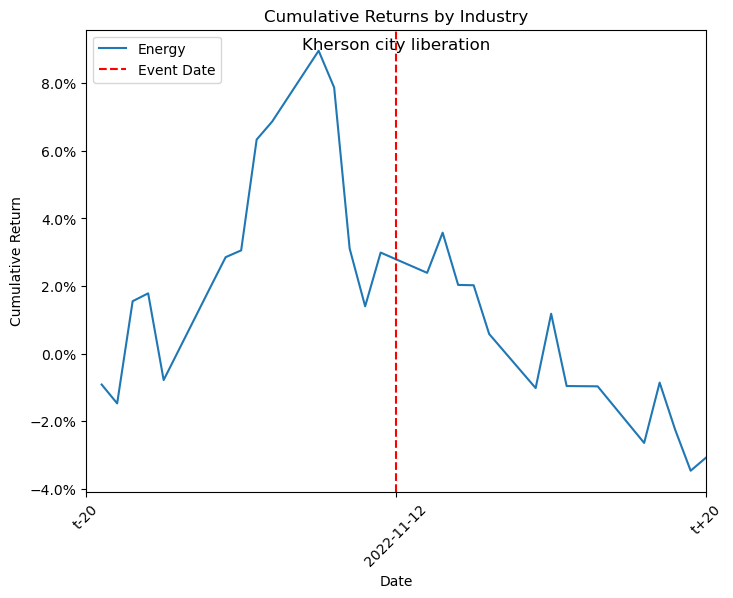

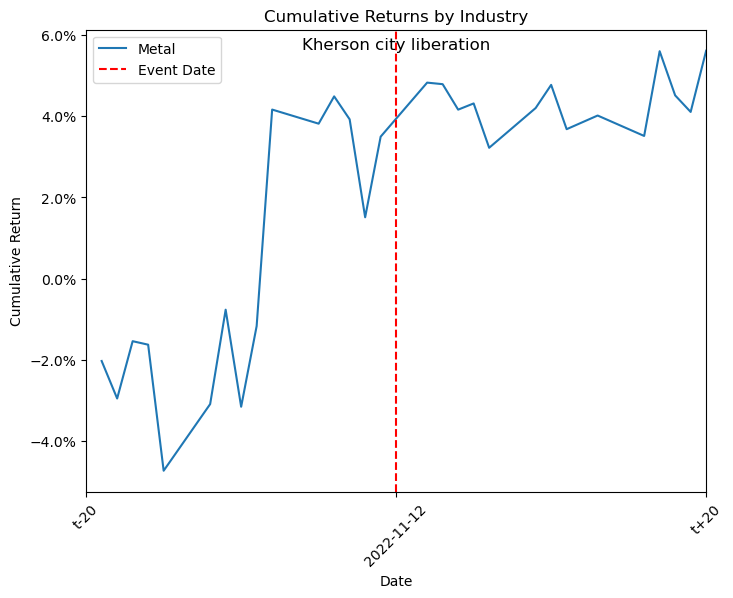

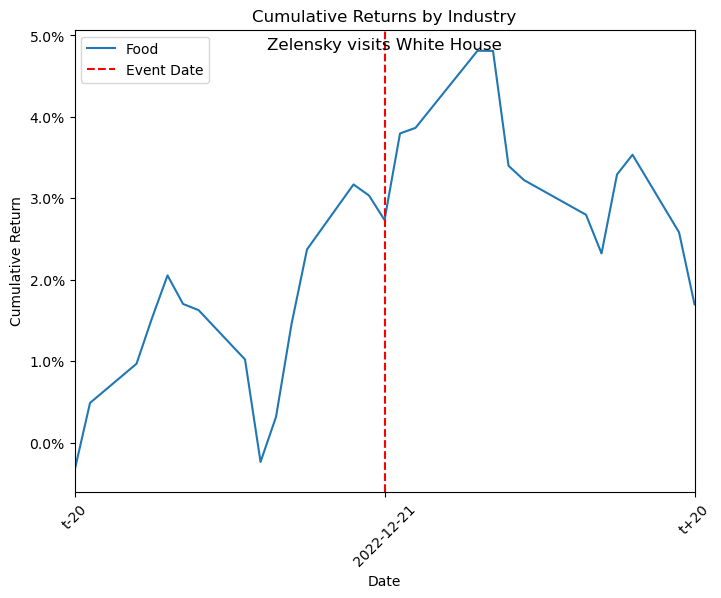

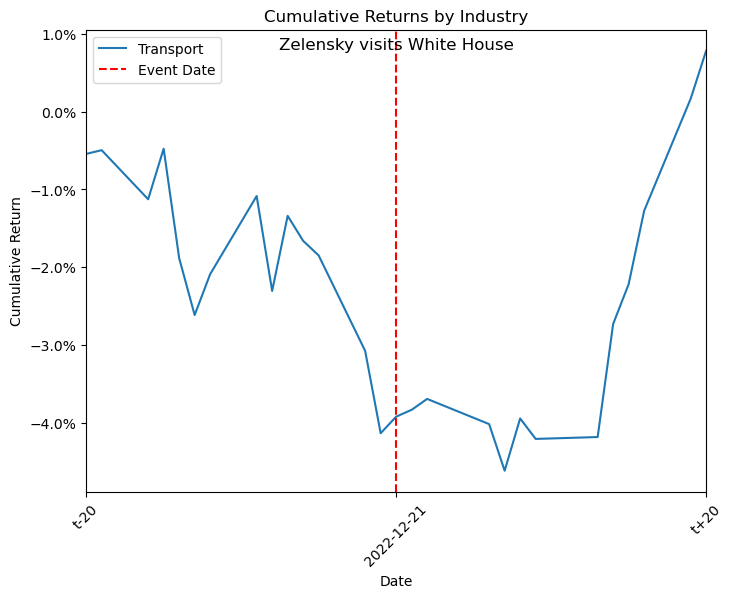

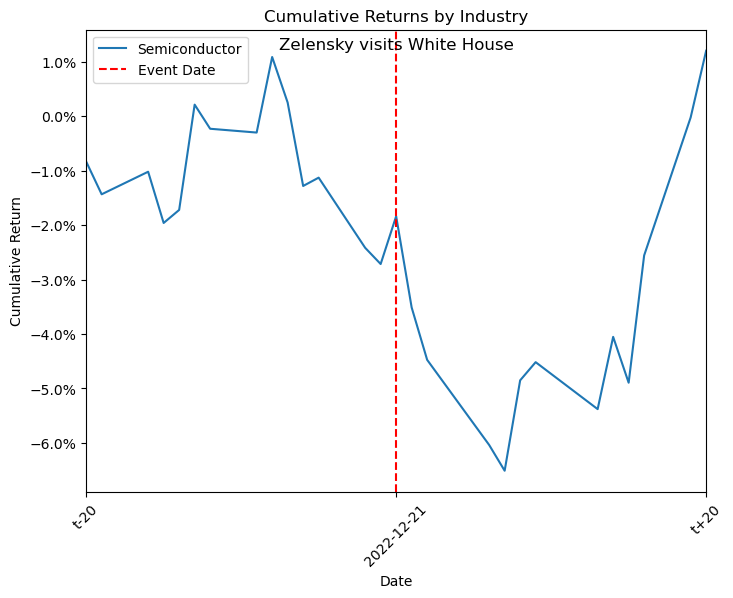

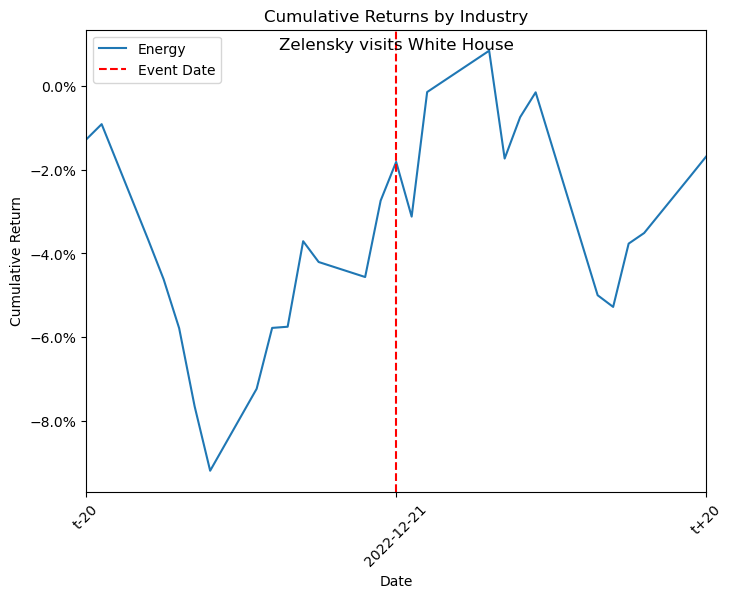

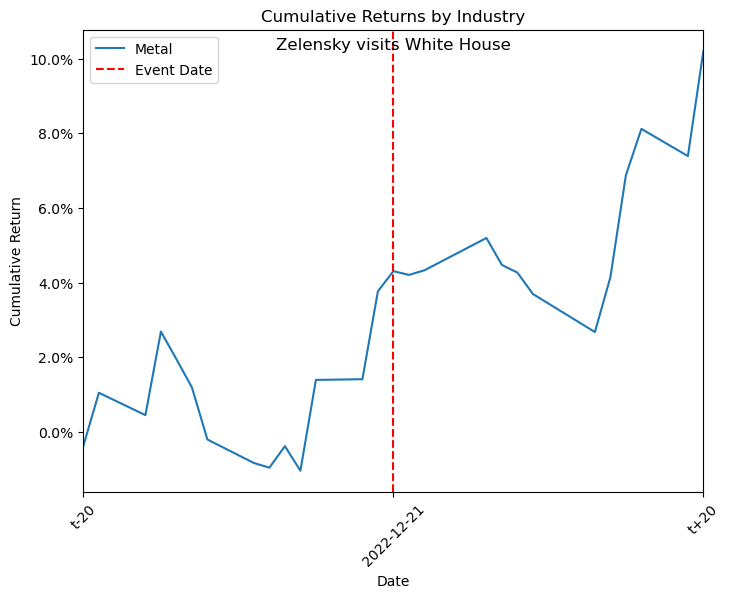

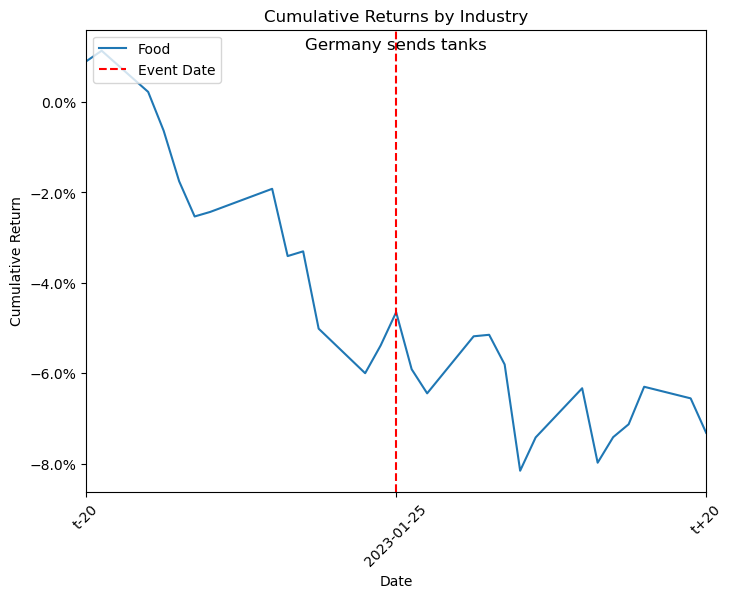

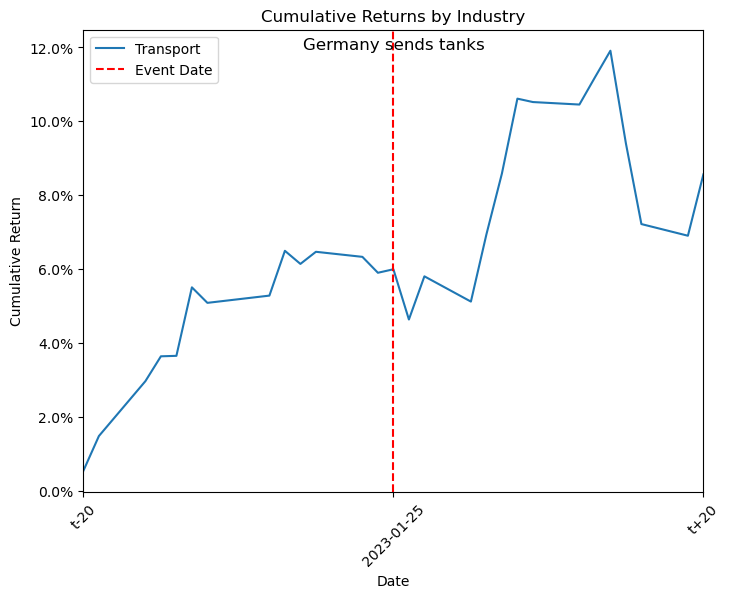

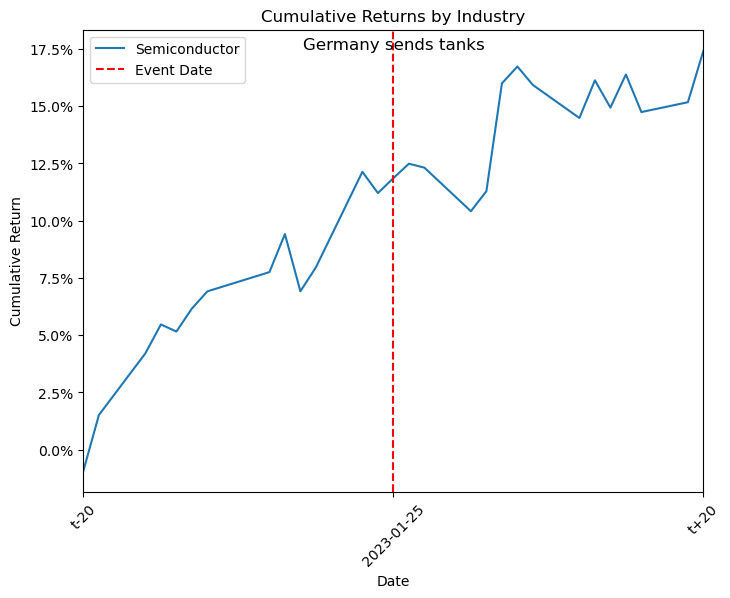

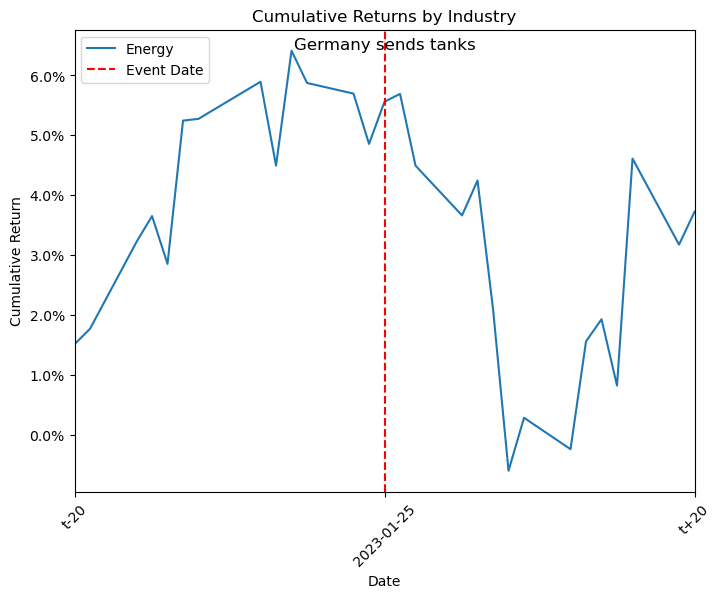

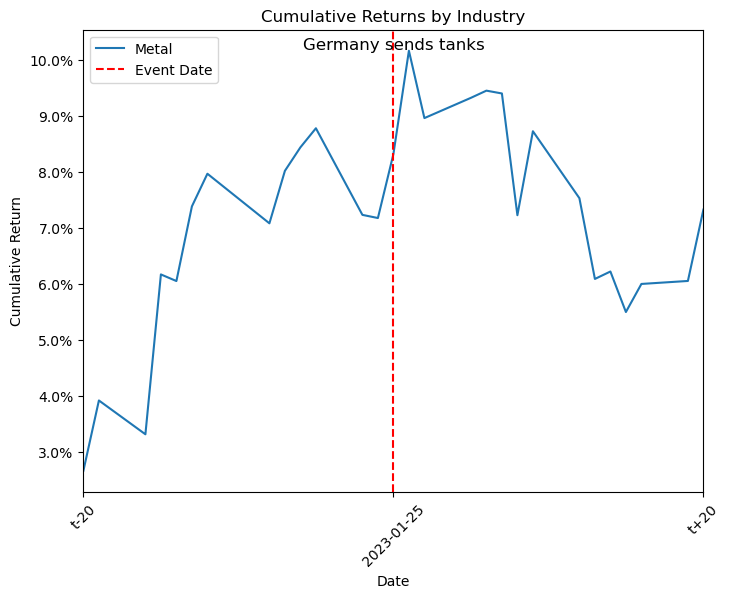

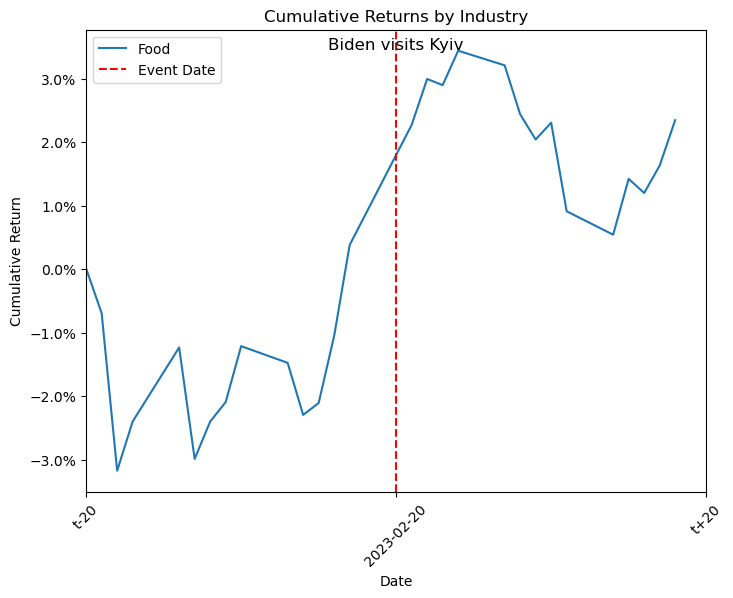

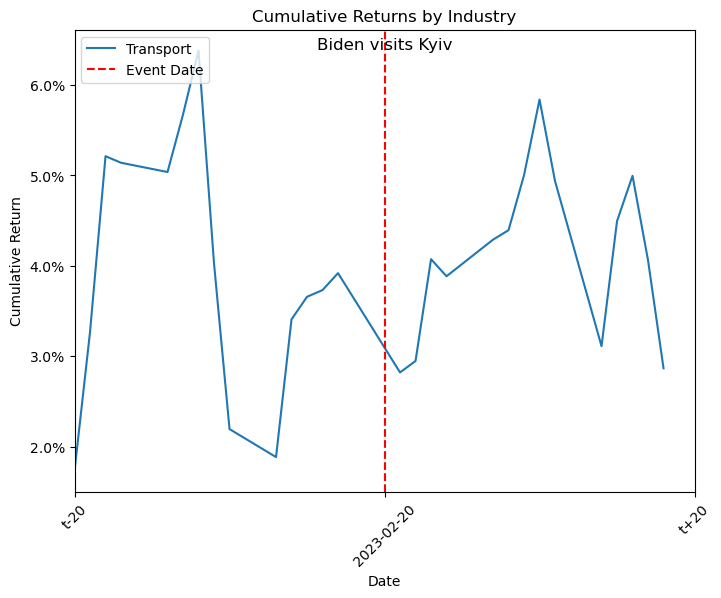

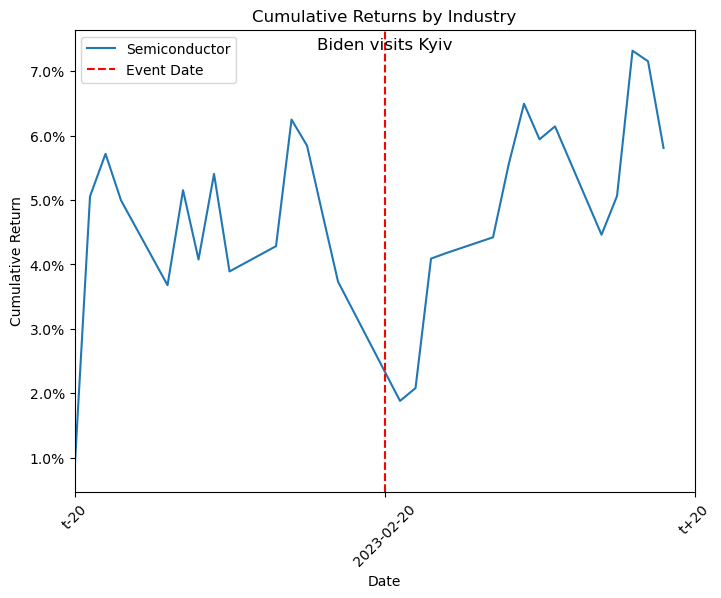

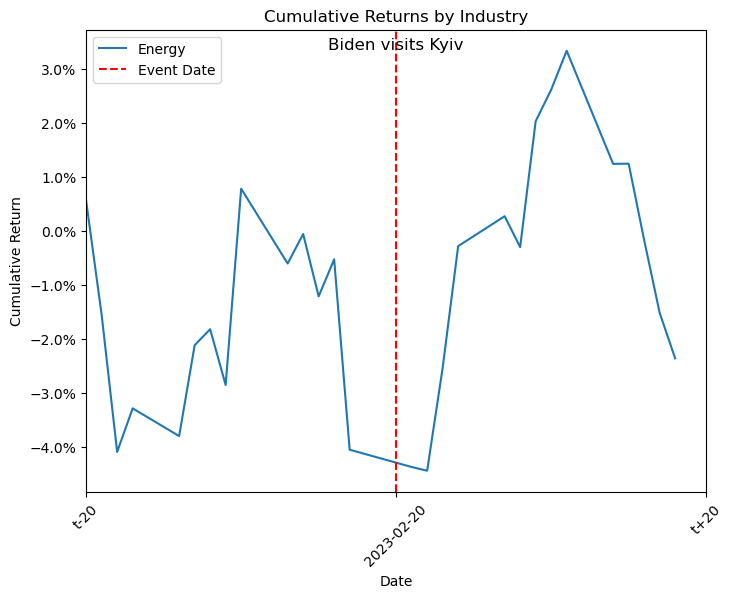

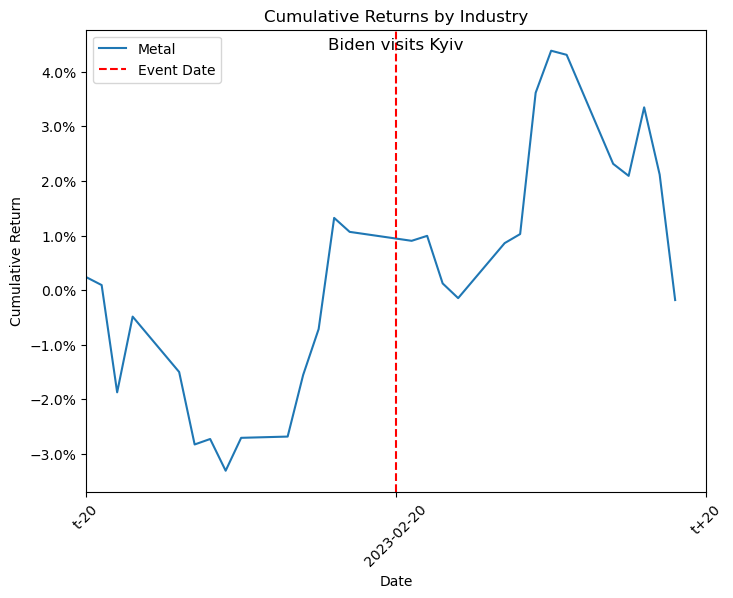

In [6]:
industries = ['Food', 'Transport', 'Semiconductor', 'Energy', 'Metal']
for index, row in event_dates.iterrows():
    event = row['Event']
    date = row['Date']
    for industry in industries:
        sub_df = event_ret_df.query("Event == @event and Industry == @industry")
        
        plt.figure(figsize=(8, 6))
        
        sns.lineplot(x='Date', y='Cum_ret', data=sub_df, label = industry)
        
        plt.axvline(date, color='red', linestyle='--', label='Event Date')
        plt.xlim(date - pd.Timedelta(days=20), date + pd.Timedelta(days=20))
        
        xticks = [date - pd.Timedelta(days=20), date, date + pd.Timedelta(days=20)]
        xticklabels = ['t-20', date.strftime('%Y-%m-%d'), 't+20']
        plt.xticks(xticks, xticklabels)
        plt.xticks(rotation=45)
        
        plt.title('Cumulative Returns by Industry')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        
        ymin, ymax = plt.ylim()
        y_pos = ymax - (ymax - ymin) * 0.05

        # add text to plot
        plt.text(date, y_pos, event, fontsize=12,
                 ha='center', va='bottom')

        # move the legend to the bottom right corner
        plt.legend(loc='lower right')
        plt.legend(loc='upper left')

        plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))  # format y-axis as percentages

        # show the plot
        plt.show()